# Esperimenti di Classificazione EEG per Demenze
 
## Obiettivi della Sezione
1. **Preprocessing e Segmentazione**: Preparazione ottimale dei dati EEG
2. **Baseline Models**: Confronto tra EEGNetv4 e Deep4Net
3. **Leave-One-Subject-Out (LOSO)**: Validazione robusta per generalizzazione
4. **Ottimizzazione Hyperparameter**: Trovare i parametri ottimali
5. **Analisi Comparativa**: Confronto sistematico dei risultati
 
## Configurazione Sperimentale
- **Architetture**: EEGNetv4, Deep4Net
- **Classificazioni**: Binarie e multiclasse
- **Validazione**: LOSO cross-validation
- **Metriche**: Accuracy, Precision, Recall, F1-score

In [1]:
import pandas as pd
from braindecode.models import EEGNetv4

In [2]:
df = pd.read_csv("Data/participants.tsv", sep="\t")

In [3]:
import mne
import os
import numpy as np
import re
import pandas as pd

#TODO: Warning: NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


base_path = "Data"
desired_channels = ['C3', 'C4', 'Cz', 'F3', 'F4', 'F7', 'F8',
                    'Fp1', 'Fp2', 'Fz', 'O1', 'O2', 'P3', 'P4',
                    'Pz', 'T3', 'T4', 'T5', 'T6']
desired_n_times = 1000  # Numero di campioni per segmento
desired_sfreq = 500     # Frequenza di campionamento desiderata (Hz)

patient_epochs = []
patient_labels = []  # Lista per salvare le label per ogni segmento (epoch)

def extract_subject_number(subdir_name):
    match = re.search(r'\d+', subdir_name)
    return int(match.group()) if match else float('inf')

# Ottieni e ordina le sottodirectory dei soggetti
subdirs = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]
subdirs_sorted = sorted(subdirs, key=extract_subject_number)


subject_to_recordings = {} # per salvare le registrazioni per ogni soggetto

for subdir in subdirs_sorted:
    subdir_path = os.path.join(base_path, subdir)
    eeg_path = os.path.join(subdir_path, 'eeg')
    if os.path.isdir(eeg_path):
        # Trova il file .set (EEGLAB)
        set_file = next((f for f in os.listdir(eeg_path) if f.endswith('.set')), None)
        if set_file:
            set_path = os.path.join(eeg_path, set_file)
            raw = mne.io.read_raw_eeglab(set_path, preload=True)
            
            # Seleziona solo i canali desiderati
            raw.pick_channels(desired_channels)
            
            # Risample se necessario
            if raw.info['sfreq'] != desired_sfreq:
                raw.resample(desired_sfreq)
            
            # Ottieni il numero di campioni della registrazione (puoi anche usare il JSON, se presente)
            n_samples = raw.n_times  
              
            
          
            # Suddividi l'intera registrazione in segmenti di 'desired_n_times' campioni
            segments = []
            for start in range(0, n_samples, desired_n_times):
                end = start + desired_n_times
                if end <= n_samples:
                    seg_data = raw[:, start:end][0]
                else:
                    # Se l'ultimo segmento è più corto, aggiungi padding con zeri
                    seg_data = raw[:, start:n_samples][0]
                    padding = np.zeros((len(desired_channels), desired_n_times - seg_data.shape[1]))
                    seg_data = np.hstack((seg_data, padding))
                segments.append(seg_data)
                 
            
            # Crea un array 3D: (numero_di_segmenti, numero_di_canali, desired_n_times)
            epochs_data = np.array(segments)
            n_epochs = epochs_data.shape[0]
            
            # Crea l'oggetto info e l'array degli eventi con tempi univoci
            info = mne.create_info(ch_names=desired_channels, sfreq=desired_sfreq, ch_types='eeg')
            events = np.array([[i * desired_n_times, 0, 1] for i in range(n_epochs)])
            
            epochs = mne.EpochsArray(epochs_data, info=info, events=events)
            patient_epochs.append(epochs)
            
            # Associa la label del soggetto: cerca in df la riga in cui la colonna 'Subject' corrisponde a subdir
            subj_label = df.loc[df['participant_id'] == subdir, 'Group'].values[0]
            # Ripeti la label per ogni segmento estratto per questo soggetto
            patient_labels.extend([subj_label] * n_epochs)

            if subdir not in subject_to_recordings:
                subject_to_recordings[subdir] = []
            subject_to_recordings[subdir].extend(segments)
        else:
            print(f"Nessun file .set trovato in {eeg_path}")
    else:
        print(f"La directory {eeg_path} non esiste.")

if patient_epochs:
    combined_epochs = mne.concatenate_epochs(patient_epochs)
    combined_labels = np.array(patient_labels)
    print("Epoche dei pazienti combinate con successo.")
    print(f"Numero totale di epoche: {len(combined_epochs)}")
    print(f"Numero totale di label: {len(combined_labels)}")
else:
    raise ValueError("Nessuna epoca disponibile per il training.")

# Ora X sarà l'array dei dati con shape (totale_epoche, n_canali, n_times)
X = combined_epochs.get_data()
# E y sarà l'array delle etichette, lungo come X
print(f"X shape: {X.shape}")
print(f"y shape: {combined_labels.shape}")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
300 matching events found
No baseline correction applied
0 projection items activated
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
397 matching events found
No baseline correction applied
0 projection items activated
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
154 matching events found
No baseline correction applied
0 projection items activated
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
354 matching events found
No baseline correction applied
0 projection items activated
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
403 matching events found
No baseline correction applied
0 projection items activated
NOTE: pick_channels() is a legacy function. New code should use i

# Test Lunghezza segmenti

In [5]:
import pandas as pd
import mne
import os
import numpy as np
import re

def analyze_subject_recordings(base_path, df):
    """
    Analizza ogni registrazione per capire le differenze nella durata
    """
    analysis_results = []
    
    desired_channels = ['C3', 'C4', 'Cz', 'F3', 'F4', 'F7', 'F8',
                        'Fp1', 'Fp2', 'Fz', 'O1', 'O2', 'P3', 'P4',
                        'Pz', 'T3', 'T4', 'T5', 'T6']
    desired_n_times = 1000
    desired_sfreq = 500
    
    def extract_subject_number(subdir_name):
        match = re.search(r'\d+', subdir_name)
        return int(match.group()) if match else float('inf')

    subdirs = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]
    subdirs_sorted = sorted(subdirs, key=extract_subject_number)
    
    subject_to_recordings = {}
    
    for subdir in subdirs_sorted:
        subdir_path = os.path.join(base_path, subdir)
        eeg_path = os.path.join(subdir_path, 'eeg')
        
        if os.path.isdir(eeg_path):
            set_file = next((f for f in os.listdir(eeg_path) if f.endswith('.set')), None)
            if set_file:
                try:
                    set_path = os.path.join(eeg_path, set_file)
                    raw = mne.io.read_raw_eeglab(set_path, preload=True)
                    
                    # 🔍 DEBUG: Informazioni PRIMA del processing
                    original_sfreq = raw.info['sfreq']
                    original_duration = raw.n_times / original_sfreq
                    original_duration_min = original_duration / 60
                    
                    print(f"\n📊 {subdir}:")
                    print(f"   Freq originale: {original_sfreq} Hz")
                    print(f"   Durata originale: {original_duration:.1f} sec ({original_duration_min:.1f} min)")
                    print(f"   Campioni originali: {raw.n_times}")
                    
                    # Seleziona canali
                    raw.pick_channels(desired_channels)
                    
                    # Resample
                    if raw.info['sfreq'] != desired_sfreq:
                        raw.resample(desired_sfreq)
                        print(f"   Dopo resample: {raw.n_times} campioni ({raw.n_times/desired_sfreq:.1f} sec)")
                    
                    n_samples = raw.n_times
                    
                    # DEBUG: Calcolo segmenti  
                    expected_segments = n_samples // desired_n_times
                    remainder = n_samples % desired_n_times
                    actual_segments = expected_segments + (1 if remainder > 0 else 0)
                    
                    print(f"   Segmenti calcolati: {expected_segments} + {1 if remainder > 0 else 0} = {actual_segments}")
                    print(f"   Campioni rimanenti: {remainder}")
                    
                    # Crea segmenti
                    segments = []
                    for start in range(0, n_samples, desired_n_times):
                        end = start + desired_n_times
                        if end <= n_samples:
                            seg_data = raw[:, start:end][0]
                        else:
                            seg_data = raw[:, start:n_samples][0]
                            padding = np.zeros((len(desired_channels), desired_n_times - seg_data.shape[1]))
                            seg_data = np.hstack((seg_data, padding))
                            print(f"\tUltimo segmento con padding: {seg_data.shape[1] - padding.shape[1]} campioni reali")
                        segments.append(seg_data)
                    
                    print(f"SEGMENTI effettivi creati: {len(segments)}")
                    
                    # coerenza?
                    if len(segments) != actual_segments:
                        print(f"INCONSISTENZA: Previsti {actual_segments}, creati {len(segments)}")
                    
                    # Ottieni il gruppo del soggetto
                    subject_group = df.loc[df['participant_id'] == subdir, 'Group'].values
                    group = subject_group[0] if len(subject_group) > 0 else 'Unknown'
                    
                    # Aggiungi i risultati
                    analysis_results.append({
                        'subject_id': subdir,
                        'group': group,
                        'original_sfreq': original_sfreq,
                        'original_duration_sec': original_duration,
                        'original_duration_min': original_duration_min,
                        'original_n_samples': raw.n_times if raw.info['sfreq'] == desired_sfreq else int(raw.n_times * (desired_sfreq / original_sfreq)),
                        'resampled_n_samples': n_samples,
                        'expected_segments': expected_segments,
                        'n_segments': len(segments),
                        'remainder_samples': remainder,
                        'has_padding': remainder > 0
                    })
                    
                    # Salva i segmenti
                    if subdir not in subject_to_recordings:
                        subject_to_recordings[subdir] = []
                    subject_to_recordings[subdir].extend(segments)
                
                #Aggiunti per un eventuale applicazione generale
                except Exception as e:
                    print(f"Errore nel processare {subdir}: {str(e)}")
                    analysis_results.append({
                        'subject_id': subdir,
                        'group': 'Error',
                        'original_sfreq': np.nan,
                        'original_duration_sec': np.nan,
                        'original_duration_min': np.nan,
                        'original_n_samples': np.nan,
                        'resampled_n_samples': np.nan,
                        'expected_segments': np.nan,
                        'n_segments': 0,
                        'remainder_samples': np.nan,
                        'has_padding': False
                    })
            else:
                print(f"Nessun file .set trovato in {eeg_path}")
                analysis_results.append({
                    'subject_id': subdir,
                    'group': 'No .set file',
                    'original_sfreq': np.nan,
                    'original_duration_sec': np.nan,
                    'original_duration_min': np.nan,
                    'original_n_samples': np.nan,
                    'resampled_n_samples': np.nan,
                    'expected_segments': np.nan,
                    'n_segments': 0,
                    'remainder_samples': np.nan,
                    'has_padding': False
                })
        else:
            print(f"La directory {eeg_path} non esiste.")
            analysis_results.append({
                'subject_id': subdir,
                'group': 'No eeg dir',
                'original_sfreq': np.nan,
                'original_duration_sec': np.nan,
                'original_duration_min': np.nan,
                'original_n_samples': np.nan,
                'resampled_n_samples': np.nan,
                'expected_segments': np.nan,
                'n_segments': 0,
                'remainder_samples': np.nan,
                'has_padding': False
            })
    
    # Summary
    print("\n" + "="*50)
    print("SUMMARY SEGMENTAZIONE")
    print("="*50)
    for subject, recordings in subject_to_recordings.items():
        print(f"{subject}: {len(recordings)} segmenti")

    # Identifica outliers
    if subject_to_recordings:
        segment_counts = [len(recordings) for recordings in subject_to_recordings.values()]
        mean_segments = np.mean(segment_counts)
        std_segments = np.std(segment_counts)
        print(f"\nMedia: {mean_segments:.1f} ± {std_segments:.1f} segmenti")
        print(f"Range: {min(segment_counts)} - {max(segment_counts)} segmenti")

        # Identifica soggetti anomali
        outliers = []
        for subject, recordings in subject_to_recordings.items():
            n_seg = len(recordings)
            if abs(n_seg - mean_segments) > 2 * std_segments:
                outliers.append((subject, n_seg))

        if outliers:
            print(f"\nSoggetti con numero anomalo di segmenti:")
            for subject, n_seg in outliers:
                print(f"   {subject}: {n_seg} segmenti")
    
    return pd.DataFrame(analysis_results)


In [6]:

def run_analysis():
    """Funzione principale per eseguire l'analisi"""
    base_path = "Data"  
    df = pd.read_csv("Data/participants.tsv", sep="\t")  
    
    results_df = analyze_subject_recordings(base_path, df)
    
    # Analisi dei risultati
    print("=" * 80)
    print("ANALISI DELLA SEGMENTAZIONE")
    print("=" * 80)
    print()
    
    # Filtra i risultati validi (esclude errori)
    valid_results = results_df[results_df['group'].isin(['A', 'C', 'F'])]
    
    if len(valid_results) == 0:
        print("❌ Nessun risultato valido trovato!")
        return results_df
    
    # Statistiche generali
    print(f"Numero totale di soggetti analizzati: {len(results_df)}")
    print(f"Numero di soggetti validi: {len(valid_results)}")
    print()
    
    # Durata delle registrazioni
    print("DURATA DELLE REGISTRAZIONI:")
    print(f"Durata minima: {valid_results['original_duration_min'].min():.2f} minuti")
    print(f"Durata massima: {valid_results['original_duration_min'].max():.2f} minuti")
    print(f"Durata media: {valid_results['original_duration_min'].mean():.2f} ± {valid_results['original_duration_min'].std():.2f} minuti")
    print()
    
    # Frequenze di campionamento originali
    print("FREQUENZE DI CAMPIONAMENTO ORIGINALI:")
    freq_counts = valid_results['original_sfreq'].value_counts()
    for freq, count in freq_counts.items():
        print(f"  {freq} Hz: {count} soggetti")
    print()
    
    # Numero di segmenti
    print("NUMERO DI SEGMENTI:")
    print(f"Segmenti minimi: {valid_results['n_segments'].min()}")
    print(f"Segmenti massimi: {valid_results['n_segments'].max()}")
    print(f"Segmenti medi: {valid_results['n_segments'].mean():.1f} ± {valid_results['n_segments'].std():.1f}")
    print()
    
    # Identifica i casi estremi
    print("CASI ESTREMI:")
    q1 = valid_results['n_segments'].quantile(0.25)
    q3 = valid_results['n_segments'].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    outliers = valid_results[(valid_results['n_segments'] < lower_bound) | 
                            (valid_results['n_segments'] > upper_bound)]
    
    if not outliers.empty:
        print("Soggetti con numero di segmenti anomalo:")
        for _, row in outliers.iterrows():
            print(f"  {row['subject_id']}: {row['n_segments']} segmenti "
                  f"({row['original_duration_min']:.1f} min, {row['original_sfreq']} Hz)")
    else:
        print("Nessun outlier identificato")
    print()
    
    # Raggruppa per gruppo
    print("SEGMENTI PER GRUPPO:")
    group_stats = valid_results.groupby('group')['n_segments'].agg(['mean', 'std', 'min', 'max', 'count'])
    print(group_stats)
    print()
    
    # Salva i risultati
    results_df.to_csv('subject_segmentation_analysis.csv', index=False)
    print("Risultati salvati in 'subject_segmentation_analysis.csv'")
    
    return results_df


def plot_analysis(results_df):
    """
    Crea grafici per visualizzare l'analisi
    """
    import matplotlib.pyplot as plt
    
    # Filtra risultati validi
    valid_results = results_df[results_df['group'].isin(['A', 'C', 'F'])]
    
    if len(valid_results) == 0:
        print("❌ Nessun dato valido per i grafici!")
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Distribuzione durata registrazioni
    axes[0,0].hist(valid_results['original_duration_min'], bins=20, alpha=0.7, edgecolor='black')
    axes[0,0].set_xlabel('Durata (minuti)')
    axes[0,0].set_ylabel('Frequenza')
    axes[0,0].set_title('Distribuzione Durata Registrazioni')
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. Distribuzione numero segmenti
    axes[0,1].hist(valid_results['n_segments'], bins=20, alpha=0.7, edgecolor='black')
    axes[0,1].set_xlabel('Numero Segmenti')
    axes[0,1].set_ylabel('Frequenza')
    axes[0,1].set_title('Distribuzione Numero Segmenti')
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Correlazione durata vs segmenti
    axes[1,0].scatter(valid_results['original_duration_min'], valid_results['n_segments'], alpha=0.6)
    axes[1,0].set_xlabel('Durata (minuti)')
    axes[1,0].set_ylabel('Numero Segmenti')
    axes[1,0].set_title('Durata vs Numero Segmenti')
    axes[1,0].grid(True, alpha=0.3)
    
    # 4. Boxplot per gruppo
    if len(valid_results['group'].unique()) > 1:
        valid_results.boxplot(column='n_segments', by='group', ax=axes[1,1])
        axes[1,1].set_title('Segmenti per Gruppo')
        axes[1,1].set_xlabel('Gruppo')
        axes[1,1].set_ylabel('Numero Segmenti')
    else:
        axes[1,1].text(0.5, 0.5, 'Boxplot per gruppo\nnon disponibile', 
                      ha='center', va='center', transform=axes[1,1].transAxes)
        axes[1,1].set_title('Boxplot per Gruppo')
    
    plt.tight_layout()
    plt.savefig('segmentation_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

In [7]:
result_run_analysis = run_analysis()


📊 sub-001:
   Freq originale: 500.0 Hz
   Durata originale: 599.8 sec (10.0 min)
   Campioni originali: 299900
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
   Segmenti calcolati: 299 + 1 = 300
   Campioni rimanenti: 900
	Ultimo segmento con padding: 900 campioni reali
SEGMENTI effettivi creati: 300

📊 sub-002:
   Freq originale: 500.0 Hz
   Durata originale: 793.1 sec (13.2 min)
   Campioni originali: 396550
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
   Segmenti calcolati: 396 + 1 = 397
   Campioni rimanenti: 550
	Ultimo segmento con padding: 550 campioni reali
SEGMENTI effettivi creati: 397

📊 sub-003:
   Freq originale: 500.0 Hz
   Durata originale: 307.1 sec (5.1 min)
   Campioni originali: 153550
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
   Segmenti calcolati: 153 + 1 = 154
   Campioni rimanenti: 550
	Ultimo segmento con padding: 550 campioni reali
SEGMENTI effettivi creat

In [8]:
result_run_analysis.dropna(inplace=True)
result_run_analysis

,subject_id,group,original_sfreq,original_duration_sec,original_duration_min,original_n_samples,resampled_n_samples,expected_segments,n_segments,remainder_samples,has_padding
0,sub-001,A,500.0,599.8,9.996667,299900.0,299900.0,299.0,300,900.0,True
1,sub-002,A,500.0,793.1,13.218333,396550.0,396550.0,396.0,397,550.0,True
2,sub-003,A,500.0,307.1,5.118333,153550.0,153550.0,153.0,154,550.0,True
3,sub-004,A,500.0,707.1,11.785000,353550.0,353550.0,353.0,354,550.0,True
4,sub-005,A,500.0,804.1,13.401667,402050.0,402050.0,402.0,403,50.0,True
...,...,...,...,...,...,...,...,...,...,...,...
83,sub-084,F,500.0,652.1,10.868333,326050.0,326050.0,326.0,327,50.0,True
84,sub-085,F,500.0,566.1,9.435000,283050.0,283050.0,283.0,284,50.0,True
85,sub-086,F,500.0,655.6,10.926667,327800.0,327800.0,327.0,328,800.0,True
86,sub-087,F,500.0,606.1,10.101667,303050.0,303050.0,303.0,304,50.0,True


In [9]:
result_run_analysis['original_duration_min'].sum()

1176.505

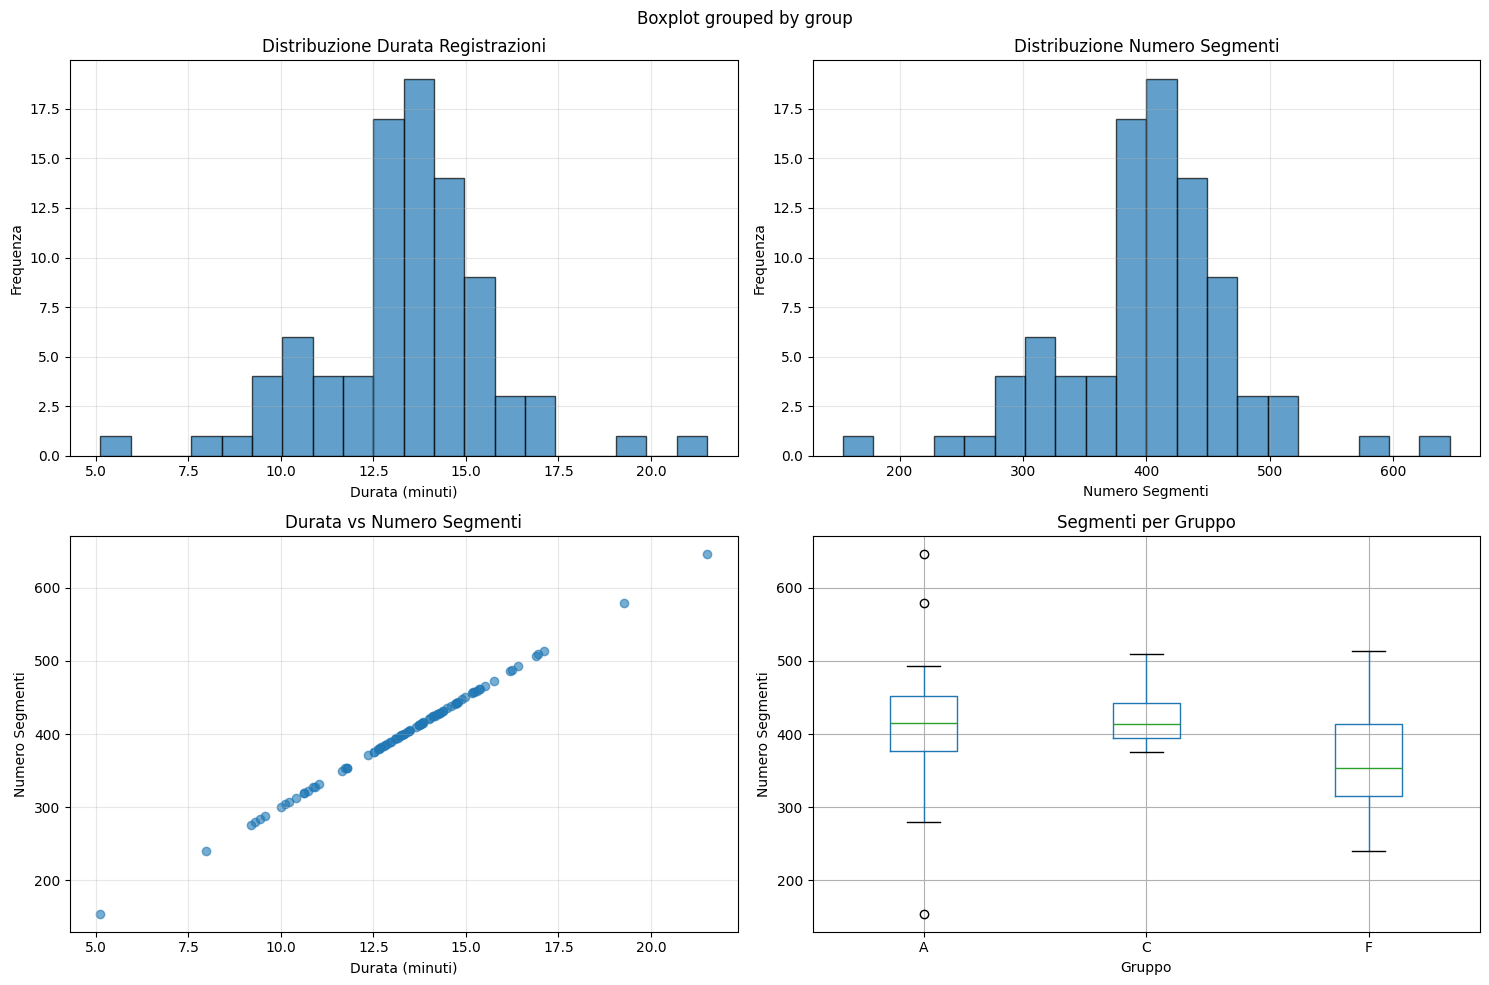

In [10]:
plot_analysis(result_run_analysis)

# Model experiment

## First model: EEGNetv4

In [4]:
model = EEGNetv4(
    n_chans=19, # Scritto nelle sotto dir
    n_times = 1000, 
    n_outputs = 3, # num of classes -> A,C,F
    final_conv_length='auto',
)
print(model)

Layer (type (var_name):depth-idx)                  Input Shape               Output Shape              Param #                   Kernel Shape
EEGNetv4 (EEGNetv4)                                [1, 19, 1000]             [1, 3]                    --                        --
├─Ensure4d (ensuredims): 1-1                       [1, 19, 1000]             [1, 19, 1000, 1]          --                        --
├─Rearrange (dimshuffle): 1-2                      [1, 19, 1000, 1]          [1, 1, 19, 1000]          --                        --
├─Conv2d (conv_temporal): 1-3                      [1, 1, 19, 1000]          [1, 8, 19, 1001]          512                       [1, 64]
├─BatchNorm2d (bnorm_temporal): 1-4                [1, 8, 19, 1001]          [1, 8, 19, 1001]          16                        --
├─Conv2dWithConstraint (conv_spatial): 1-5         [1, 8, 19, 1001]          [1, 16, 1, 1001]          304                       [19, 1]
├─BatchNorm2d (bnorm_1): 1-6                       [1, 1

In [5]:
from skorch.dataset import ValidSplit
from braindecode import EEGClassifier
from torch.nn import CrossEntropyLoss
from skorch.callbacks import EarlyStopping

# La configurazione della rete
net = EEGClassifier(
    'EEGNetv4',
    callbacks=[
        EarlyStopping(patience=10, threshold=0.001, monitor='valid_loss')
    ],
    module__final_conv_length='auto',
    train_split = ValidSplit(0.3),
    batch_size = 32,
    lr = 0.005,
    max_epochs = 50,
    criterion = CrossEntropyLoss(),
)

In [ ]:
#Addestramento della rete con tutti i soggetti 

#Mapping da Label a intero
label_mapping = {'A': 0, 'C': 1, 'F': 2}

# Dati delle epoche
X = combined_epochs.get_data()  # : (n_epochs, n_channels, n_times)

# Etichette delle epoche
y = np.array([label_mapping[label] for label in patient_labels])

# Addestra la rete
net.fit(X, y)

In [17]:
#Label reali del soggetto
true_labels = {}
for i in range(len(df)):
    true_labels[df.iloc[i]['participant_id']] = df.iloc[i]['Group']
print(true_labels)

{'sub-001': 'A', 'sub-002': 'A', 'sub-003': 'A', 'sub-004': 'A', 'sub-005': 'A', 'sub-006': 'A', 'sub-007': 'A', 'sub-008': 'A', 'sub-009': 'A', 'sub-010': 'A', 'sub-011': 'A', 'sub-012': 'A', 'sub-013': 'A', 'sub-014': 'A', 'sub-015': 'A', 'sub-016': 'A', 'sub-017': 'A', 'sub-018': 'A', 'sub-019': 'A', 'sub-020': 'A', 'sub-021': 'A', 'sub-022': 'A', 'sub-023': 'A', 'sub-024': 'A', 'sub-025': 'A', 'sub-026': 'A', 'sub-027': 'A', 'sub-028': 'A', 'sub-029': 'A', 'sub-030': 'A', 'sub-031': 'A', 'sub-032': 'A', 'sub-033': 'A', 'sub-034': 'A', 'sub-035': 'A', 'sub-036': 'A', 'sub-037': 'C', 'sub-038': 'C', 'sub-039': 'C', 'sub-040': 'C', 'sub-041': 'C', 'sub-042': 'C', 'sub-043': 'C', 'sub-044': 'C', 'sub-045': 'C', 'sub-046': 'C', 'sub-047': 'C', 'sub-048': 'C', 'sub-049': 'C', 'sub-050': 'C', 'sub-051': 'C', 'sub-052': 'C', 'sub-053': 'C', 'sub-054': 'C', 'sub-055': 'C', 'sub-056': 'C', 'sub-057': 'C', 'sub-058': 'C', 'sub-059': 'C', 'sub-060': 'C', 'sub-061': 'C', 'sub-062': 'C', 'sub-06

Predicted label for subject sub-001: A
Predicted label for subject sub-002: A
Predicted label for subject sub-003: A
Predicted label for subject sub-004: A
Predicted label for subject sub-005: A
Predicted label for subject sub-006: A
Predicted label for subject sub-007: A
Predicted label for subject sub-008: A
Predicted label for subject sub-009: A
Predicted label for subject sub-010: A
Predicted label for subject sub-011: A
Predicted label for subject sub-012: A
Predicted label for subject sub-013: A
Predicted label for subject sub-014: A
Predicted label for subject sub-015: A
Predicted label for subject sub-016: A
Predicted label for subject sub-017: A
Predicted label for subject sub-018: A
Predicted label for subject sub-019: A
Predicted label for subject sub-020: A
Predicted label for subject sub-021: A
Predicted label for subject sub-022: A
Predicted label for subject sub-023: A
Predicted label for subject sub-024: A
Predicted label for subject sub-025: A
Predicted label for subje

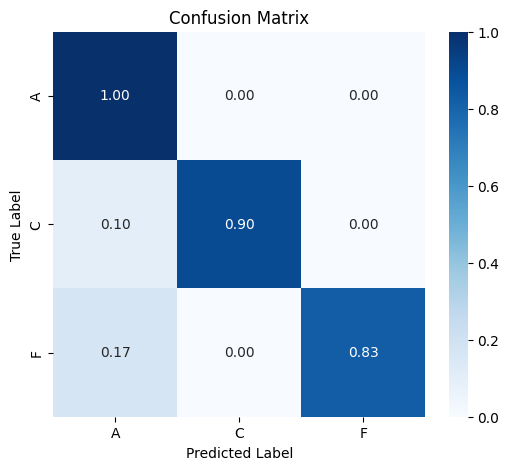

In [28]:
from scipy.stats import mode
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Funzione per valutare il modello
# e calcolare le metriche di classificazione
label_mapping = {'A': 0, 'C': 1, 'F': 2}

def evaluate_model(true_labels, subject_to_recordings, net, label_mapping):
	"""
	Valuta il modello su ogni soggetto e calcola le metriche di classificazione.
	Args:
		true_labels (dict): Dizionario con le etichette vere per ogni soggetto.
		subject_to_recordings (dict): Dizionario che mappa i soggetti alle loro registrazioni.
		net: Modello di rete neurale addestrato.
		label_mapping (dict): Mappatura delle etichette da stringa a intero.
	Returns:
		dict: Dizionario con le metriche di classificazione."""

	def check_subject_classification(subject_id):
		
		if subject_id not in subject_to_recordings:
			raise ValueError(f"Soggetto {subject_id} non trovato nelle registrazioni.")
		
		# Ottieni i segmenti associati al soggetto
		subject_segments = subject_to_recordings[subject_id]
		
		# Converti i segmenti in un array numpy
		subject_segments_array = np.stack(subject_segments) # TODO: np.array/ stack?
		
		# Prevedi le etichette per i segmenti del soggetto
		subject_predictions = net.predict(subject_segments_array)
		
		# Calcola la moda delle predizioni per determinare la classificazione complessiva del soggetto
		subject_classification = mode(subject_predictions, keepdims=True).mode[0]
		
		# Mappa l'etichetta numerica alla classe
		inverse_label_mapping = {v: k for k, v in label_mapping.items()}
		predicted_label = inverse_label_mapping[subject_classification]

		print(f"Predicted label for subject {subject_id}: {predicted_label}")
		
		return predicted_label

	# Classifica e calcola le metriche
	predicted_labels = {}
	for subject_id in true_labels.keys():
		predicted_label = check_subject_classification(subject_id)
		predicted_labels[subject_id] = predicted_label
		if predicted_label != true_labels[subject_id]:
			print(f"Classificazione errata per il soggetto {subject_id}: {predicted_label} (reale: {true_labels[subject_id]})")

	# Calcola le metriche
	tl, pl = [], []
	for k in true_labels.keys():
		tl.append(true_labels[k])
		pl.append(predicted_labels[k])

	metrics = {
		'acc': accuracy_score(tl, pl),
		'prec': precision_score(tl, pl, average='weighted'),
		'recall': recall_score(tl, pl, average='weighted'),
		'f1': f1_score(tl, pl, average='weighted'),
		'confuzion_matrix': confusion_matrix(tl, pl)
	}

	return metrics

# Chiama
stats = evaluate_model(true_labels, subject_to_recordings, net, label_mapping)
acc = stats['acc']
prec = stats['prec']
recall = stats['recall']
f1 = stats['f1']
print(f"Metrics for the model: ")
print(f"Accuracy: {acc:.2f}")
print(f"Precision: {prec:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


#Cponfusion matrix
cm = stats['confuzion_matrix']
labels = list(label_mapping.keys())

#sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels) #  non normalizata
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6, 5))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=labels, yticklabels=labels)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## First LOSO

In [19]:
from scipy.stats import mode
from sklearn.metrics import accuracy_score
import numpy as np
import os


def run_loso_experiment(all_subjects, true_labels, subject_to_recordings, label_mapping, train_fn, experiment_name="Esperimento", filename=None):
    seg_true_all = []
    seg_pred_all = []
    moda_true_all = []
    moda_pred_all = []

    segment_accuracies = []
    subject_accuracies = []

    inverse_mapping = {v: k for k, v in label_mapping.items()}

    # Abilita salvataggio se è stato fornito un percorso
    save = filename is not None
    if save:
        save_dir = os.path.join(filename, experiment_name)
        os.makedirs(save_dir, exist_ok=True)

    for left_out in all_subjects:
        model_path = os.path.join(filename, experiment_name, f"model_test_LOSO_noSubject_{left_out}.pt") if save else None

        # Verifica se il modello esiste già
        if save and os.path.exists(model_path):
            print(f"\n⏭️ Modello già salvato per {left_out}, salto...")
            continue

        print(f"\n🔍 Lascio fuori: {left_out}")
        
        # Split
        train_subjects = [s for s in all_subjects if s != left_out]
        test_subject = left_out

        # Prepara dati di training
        X_train, y_train = [], []
        for s in train_subjects:
            label = label_mapping[true_labels[s]]
            for seg in subject_to_recordings[s]:
                X_train.append(seg)
                y_train.append(label)

        X_train = np.stack(X_train)
        y_train = np.array(y_train)

        # Prepara dati di test
        X_test = np.stack(subject_to_recordings[test_subject])
        y_test = [label_mapping[true_labels[test_subject]]] * len(subject_to_recordings[test_subject])

        # Allena
        model = train_fn(X_train, y_train)

        # Salva modello
        if save:
            model.save_params(model_path)

        # Predici
        y_pred_segments = model.predict(X_test)

        # Salva per valutazione segmenti
        seg_true_all.extend(y_test)
        seg_pred_all.extend(y_pred_segments)

        acc_seg = accuracy_score(y_test, y_pred_segments)
        segment_accuracies.append(acc_seg)

        # Predizione moda per soggetto
        moda_pred = mode(y_pred_segments, keepdims=True).mode[0]
        moda_true = y_test[0]

        moda_pred_all.append(moda_pred)
        moda_true_all.append(moda_true)

        acc_moda = (moda_pred == moda_true)
        subject_accuracies.append(acc_moda)

        print(f"Accuracy segmenti: {acc_seg:.2f} - Accuracy moda: {acc_moda:.2f}")

    # METRICHE FINALI
    results = {
        'acc_segmenti': np.mean(segment_accuracies) if segment_accuracies else None,
        'acc_segmenti_std': np.std(segment_accuracies) if segment_accuracies else None,
        'acc_moda': np.mean(subject_accuracies) if subject_accuracies else None,
        'acc_moda_std': np.std(subject_accuracies) if subject_accuracies else None
    }

    print(f"\n📊 Risultati finali - {experiment_name}")
    print(f"Accuracy segmenti: {results['acc_segmenti']:.2f} ± {results['acc_segmenti_std']:.2f}")
    print(f"Accuracy moda: {results['acc_moda']:.2f} ± {results['acc_moda_std']:.2f}")

    return results


In [ ]:
import os 

experiment = [
    {
"name":  "Contro_vs_Alzheimer",
"labels" : {'C': 0, 'A': 1}
    },
    {
"name":  "Contro_vs_Frontotemporal",
"labels" : {'C': 0, 'F': 1}
    },
    {
"name":  "Frontotemporal_vs_Alzheimer",
"labels" : {'A': 0, 'F': 1}
    },
    {
"name":  "Contro_vs_Patologici",
"labels" : {'C': 0, 'A': 1, 'F': 1}
    }

]

def train_fn(X_train, y_train):
    net.fit(X_train, y_train)
    return net


memmap_dir = "experiment_loso/NETv4"

all_subjects = list(true_labels.keys())

for exp in experiment:
# Filtra solo i soggetti che appartengono alle classi desiderate (es. Contro vs Alzheimer)
    filtered_subjects = {s: l for s, l in true_labels.items() if l in list(exp['labels'].keys())}
    filtered_labels = {s: true_labels[s] for s in filtered_subjects}
    filtered_recordings = {s: subject_to_recordings[s] for s in filtered_subjects}

    print(f"Filtered subjects: {filtered_subjects.keys()}")
    print(f"number of subjects: {len(filtered_subjects)}")
    print(f"Filtered labels: { set(filtered_labels.values()) }")
    print(f"Filtered recordings: {filtered_recordings.keys()}")
    # Esegui l'esperimento

    run_loso_experiment(
        all_subjects=filtered_subjects,
        true_labels=filtered_labels,
        subject_to_recordings=filtered_recordings,
        label_mapping=exp['labels'],
        train_fn=train_fn,
        experiment_name= exp['name'],
        filename= memmap_dir
    )


Filtered subjects: dict_keys(['sub-001', 'sub-002', 'sub-003', 'sub-004', 'sub-005', 'sub-006', 'sub-007', 'sub-008', 'sub-009', 'sub-010', 'sub-011', 'sub-012', 'sub-013', 'sub-014', 'sub-015', 'sub-016', 'sub-017', 'sub-018', 'sub-019', 'sub-020', 'sub-021', 'sub-022', 'sub-023', 'sub-024', 'sub-025', 'sub-026', 'sub-027', 'sub-028', 'sub-029', 'sub-030', 'sub-031', 'sub-032', 'sub-033', 'sub-034', 'sub-035', 'sub-036', 'sub-037', 'sub-038', 'sub-039', 'sub-040', 'sub-041', 'sub-042', 'sub-043', 'sub-044', 'sub-045', 'sub-046', 'sub-047', 'sub-048', 'sub-049', 'sub-050', 'sub-051', 'sub-052', 'sub-053', 'sub-054', 'sub-055', 'sub-056', 'sub-057', 'sub-058', 'sub-059', 'sub-060', 'sub-061', 'sub-062', 'sub-063', 'sub-064', 'sub-065'])
number of subjects: 65
Filtered labels: {'A', 'C'}
Filtered recordings: dict_keys(['sub-001', 'sub-002', 'sub-003', 'sub-004', 'sub-005', 'sub-006', 'sub-007', 'sub-008', 'sub-009', 'sub-010', 'sub-011', 'sub-012', 'sub-013', 'sub-014', 'sub-015', 'sub-0

## Test epoch ottimale

In [ ]:
## DELETE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from braindecode.models import EEGNetv4
from braindecode import EEGClassifier
from skorch.dataset import ValidSplit
from skorch.callbacks import EarlyStopping, LRScheduler, PrintLog
from torch.nn import CrossEntropyLoss
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch
import mne
import os
import re
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from scipy.stats import mode
import warnings
warnings.filterwarnings('ignore')


EXPERIMENT_CONFIG = {
    'max_epochs_exploration': 200,  
    'patience_early_stopping': 25, 
    'lr_scheduler_patience': 8,    
    'lr_scheduler_factor': 0.7,    
    'batch_size': 32,
    'initial_lr': 0.005,
    'validation_split': 0.3,
    'monitor_metric': 'valid_loss',  # Metrica da monitorare 
    'plot_every_n_epochs': 10       # -> Memorizza ogni 10 epoch per il plot
}

print("Configurazione esperimento:")
for k, v in EXPERIMENT_CONFIG.items():
    print(f"  {k}: {v}")




# %%
class DetailedTrainingMonitor:
    """Classe per monitorare dettagliatamente il training e identificare overfitting"""
    
    def __init__(self, plot_every_n=10):
        self.plot_every_n = plot_every_n
        self.train_losses = []
        self.valid_losses = []
        self.train_accs = []
        self.valid_accs = []
        self.learning_rates = []  # Aggiunto per tracciare il learning rate
        self.epochs = []
        self.best_epoch = 0
        self.best_valid_loss = float('inf')
        self.overfitting_start = None
        
    def update(self, epoch, train_loss, valid_loss, train_acc=None, valid_acc=None, lr=None):
        """Aggiorna le metriche"""
        self.epochs.append(epoch)
        self.train_losses.append(train_loss)
        self.valid_losses.append(valid_loss)
        if train_acc is not None:
            self.train_accs.append(train_acc)
        if valid_acc is not None:
            self.valid_accs.append(valid_acc)
        if lr is not None:
            self.learning_rates.append(lr)
            
        # miglior epoch
        if valid_loss < self.best_valid_loss:
            self.best_valid_loss = valid_loss
            self.best_epoch = epoch
            
        # Identifica inizio overfitting ( aka validation loss inizia a risalire)
        if len(self.valid_losses) >= 3 and self.overfitting_start is None:
            recent_losses = self.valid_losses[-3:]
            if recent_losses[0] < recent_losses[1] < recent_losses[2]:
                self.overfitting_start = epoch - 2
                print(f"⚠️  Possibile inizio overfitting rilevato all'epoch {self.overfitting_start}")
    
    def plot_training_curves(self, save_path=None):
        """Plotta le curve di training"""
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        
        # Loss curves
        ax1.plot(self.epochs, self.train_losses, 'b-', label='Training Loss', linewidth=2)
        ax1.plot(self.epochs, self.valid_losses, 'r-', label='Validation Loss', linewidth=2)
        ax1.axvline(x=self.best_epoch, color='green', linestyle='--', alpha=0.7, label=f'Best Epoch ({self.best_epoch})')
        if self.overfitting_start:
            ax1.axvline(x=self.overfitting_start, color='orange', linestyle='--', alpha=0.7, 
                       label=f'Overfitting Start ({self.overfitting_start})')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.set_title('Training vs Validation Loss')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # overfitting indicator
        if len(self.train_losses) == len(self.valid_losses):
            loss_diff = np.array(self.valid_losses) - np.array(self.train_losses)
            ax2.plot(self.epochs, loss_diff, 'purple', linewidth=2)
            ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
            ax2.set_xlabel('Epoch')
            ax2.set_ylabel('Validation Loss - Training Loss')
            ax2.set_title('Overfitting Indicator (>0 = overfitting risk)')
            ax2.grid(True, alpha=0.3)
        
        # Accuracy curves 
        if self.train_accs and self.valid_accs:
            ax3.plot(self.epochs, self.train_accs, 'b-', label='Training Accuracy', linewidth=2)
            ax3.plot(self.epochs, self.valid_accs, 'r-', label='Validation Accuracy', linewidth=2)
            ax3.axvline(x=self.best_epoch, color='green', linestyle='--', alpha=0.7)
            ax3.set_xlabel('Epoch')
            ax3.set_ylabel('Accuracy')
            ax3.set_title('Training vs Validation Accuracy')
            ax3.legend()
            ax3.grid(True, alpha=0.3)
        
        # ✅ COMPLETATO: Learning rate evolution
        if self.learning_rates:
            ax4.plot(self.epochs, self.learning_rates, 'orange', linewidth=2, marker='o', markersize=4)
            ax4.set_xlabel('Epoch')
            ax4.set_ylabel('Learning Rate')
            ax4.set_title('Learning Rate Schedule')
            ax4.set_yscale('log')  # Scala logaritmica per meglio visualizzare i cambiamenti
            ax4.grid(True, alpha=0.3)
            
            # Evidenzia i punti dove il LR è stato ridotto
            if len(self.learning_rates) > 1:
                lr_reductions = []
                for i in range(1, len(self.learning_rates)):
                    if self.learning_rates[i] < self.learning_rates[i-1] * 0.99:  # Soglia per rilevare riduzioni significative
                        lr_reductions.append(i)
                
                if lr_reductions:
                    reduction_epochs = [self.epochs[i] for i in lr_reductions]
                    reduction_lrs = [self.learning_rates[i] for i in lr_reductions]
                    ax4.scatter(reduction_epochs, reduction_lrs, color='red', s=100, 
                              marker='v', label='LR Reductions', zorder=5)
                    ax4.legend()
                    
            # Aggiungi annotazioni per il LR iniziale e finale
            if len(self.learning_rates) >= 2:
                ax4.annotate(f'Initial: {self.learning_rates[0]:.6f}', 
                           xy=(self.epochs[0], self.learning_rates[0]), 
                           xytext=(10, 10), textcoords='offset points',
                           bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.7),
                           fontsize=9)
                ax4.annotate(f'Final: {self.learning_rates[-1]:.6f}', 
                           xy=(self.epochs[-1], self.learning_rates[-1]), 
                           xytext=(-60, 10), textcoords='offset points',
                           bbox=dict(boxstyle='round,pad=0.3', facecolor='lightcoral', alpha=0.7),
                           fontsize=9)
        else:
            # Fallback se non ci sono dati sul learning rate
            ax4.text(0.5, 0.5, 'Learning Rate data\nnot available\n\n(Enable LR tracking\nin training loop)', 
                    ha='center', va='center', transform=ax4.transAxes, fontsize=12,
                    bbox=dict(boxstyle='round,pad=0.5', facecolor='lightyellow', alpha=0.8))
            ax4.set_title('Learning Rate Schedule')
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
        
    def get_recommendations(self):
        """Fornisce raccomandazioni basate sull'analisi"""
        recommendations = []
        
        if self.overfitting_start:
            recommendations.append(f"🎯 RACCOMANDAZIONE: Ferma il training all'epoch {self.overfitting_start}")
            recommendations.append(f"   Risparmio: {len(self.epochs) - self.overfitting_start} epoch inutili")
        
        if self.best_epoch < len(self.epochs) * 0.8:
            recommendations.append(f"✅ Il miglior modello è all'epoch {self.best_epoch}")
            recommendations.append("   Il training potrebbe essere accorciato")
        
        # Analizza trend delle ultime epoch
        if len(self.valid_losses) >= 10:
            recent_trend = np.polyfit(range(10), self.valid_losses[-10:], 1)[0]
            if recent_trend > 0.001:
                recommendations.append("📈 Validation loss in crescita: possibile overfitting")
            elif recent_trend < -0.001:
                recommendations.append("📉 Validation loss ancora in discesa: potresti continuare")
            else:
                recommendations.append("➡️  Validation loss stabile: punto di convergenza raggiunto")
        
        # Raccomandazioni basate sul learning rate
        if self.learning_rates and len(self.learning_rates) > 1:
            final_lr = self.learning_rates[-1]
            initial_lr = self.learning_rates[0]
            lr_reduction_ratio = final_lr / initial_lr
            
            if lr_reduction_ratio < 0.1:
                recommendations.append(f"📉 Learning rate ridotto significativamente ({lr_reduction_ratio:.4f}x)")
                recommendations.append("   Il modello ha raggiunto una fase di fine-tuning")
            elif lr_reduction_ratio > 0.8:
                recommendations.append("➡️  Learning rate stabile: potresti aver bisogno di più epoch")
        
        return recommendations

# %%
def create_enhanced_classifier(config, net = None):
    """Crea un classificatore con monitoraggio avanzato"""
    
    callbacks = [
        EarlyStopping(
            patience=config['patience_early_stopping'], 
            threshold=0.0001, 
            monitor=config['monitor_metric'],
            lower_is_better=True
        ),
        LRScheduler(
            ReduceLROnPlateau, 
            patience=config['lr_scheduler_patience'], 
            factor=config['lr_scheduler_factor'],
            monitor=config['monitor_metric']
        ),
        PrintLog()
    ]
    
    if not net: 
        net = EEGClassifier(
            'EEGNetv4',
            module__n_chans=19,
            module__n_times=1000,  
            module__n_outputs=3,
            module__final_conv_length='auto',
            train_split=ValidSplit(config['validation_split']),
            batch_size=config['batch_size'],
            lr=config['initial_lr'],
            max_epochs=config['max_epochs_exploration'],
            criterion=CrossEntropyLoss(),
            callbacks=callbacks,
            device='cuda' if torch.cuda.is_available() else 'cpu'
        )
    
    return net

# %%
def run_extended_training_experiment(X, y, config, experiment_name="Extended_Training", net = None):
    """Esegue un esperimento di training prolungato con monitoraggio dettagliato"""
    
    print(f"\n🚀 Avvio esperimento: {experiment_name}")
    print(f"📊 Dati: {X.shape[0]} campioni, {X.shape[1]} canali, {X.shape[2]} time points")
    print(f"🎯 Classi: {len(np.unique(y))} ({np.unique(y)})")
    print(f"⏱️  Training fino a {config['max_epochs_exploration']} epoch (con early stopping)")
    
    # Crea il modello
    net = create_enhanced_classifier(config, net)
    monitor = DetailedTrainingMonitor(config['plot_every_n_epochs'])
    
    # Addestramento
    print("\n📈 Inizio training...")
    net.fit(X, y)
    
    # Estrai la storia del training
    history = net.history
    
    # Popola il monitor con i dati storici
    for i, epoch_data in enumerate(history):
        train_loss = epoch_data.get('train_loss', 0)
        valid_loss = epoch_data.get('valid_loss', 0)
        train_acc = epoch_data.get('train_acc', None) ##TODO: change here
        valid_acc = epoch_data.get('valid_acc', None)
        
        # ✅ COMPLETATO: Estrai il learning rate dalla storia se disponibile
        lr = None
        if hasattr(net, 'optimizer_') and hasattr(net.optimizer_, 'param_groups'):
            # Prova a estrarre il learning rate corrente
            try:
                lr = net.optimizer_.param_groups[0]['lr']
            except:
                # Se fallisce, usa il learning rate dall'epoca precedente o quello iniziale
                if i == 0:
                    lr = config['initial_lr']
                elif monitor.learning_rates:
                    lr = monitor.learning_rates[-1]  # Usa l'ultimo LR conosciuto
        elif i == 0:
            lr = config['initial_lr']  # Per la prima epoca, usa il LR iniziale
        
        monitor.update(i+1, train_loss, valid_loss, train_acc, valid_acc, lr)
        
        # Plot intermedi
        if (i+1) % config['plot_every_n_epochs'] == 0:
            lr_info = f", LR: {lr:.6f}" if lr is not None else ""
            print(f"📊 Epoch {i+1}/{len(history)} - Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}{lr_info}")
    
    # Analisi finale
    print(f"\n✅ Training completato dopo {len(history)} epoch")
    print(f"🏆 Miglior epoch: {monitor.best_epoch} (Valid Loss: {monitor.best_valid_loss:.4f})")
    
    # Plot finale
    monitor.plot_training_curves(f"{experiment_name}_training_curves.png")
    
    # Raccomandazioni
    recommendations = monitor.get_recommendations()
    print("\n💡 RACCOMANDAZIONI:")
    for rec in recommendations:
        print(rec)
    
    return net, monitor, history





# %%
# VISUALIZZAZIONE COMPARATIVA FINALE
def plot_epoch_comparison(results_comparison):
    """Plotta il confronto tra diversi numeri di epoch"""
    
    if not results_comparison:
        print("⚠️  Nessun dato di confronto disponibile")
        return
    
    epochs = list(results_comparison.keys())
    train_losses = [results_comparison[e]['final_train_loss'] for e in epochs]
    valid_losses = [results_comparison[e]['final_valid_loss'] for e in epochs]
    best_losses = [results_comparison[e]['best_valid_loss'] for e in epochs]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Loss finali
    ax1.plot(epochs, train_losses, 'b-o', label='Final Training Loss', linewidth=2, markersize=8)
    ax1.plot(epochs, valid_losses, 'r-o', label='Final Validation Loss', linewidth=2, markersize=8)
    ax1.plot(epochs, best_losses, 'g-o', label='Best Validation Loss', linewidth=2, markersize=8)
    ax1.set_xlabel('Number of Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss vs Number of Epochs')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Gap train-validation (overfitting indicator)
    gaps = np.array(valid_losses) - np.array(train_losses)
    ax2.plot(epochs, gaps, 'purple', marker='o', linewidth=2, markersize=8)
    ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax2.set_xlabel('Number of Epochs')
    ax2.set_ylabel('Validation Loss - Training Loss')
    ax2.set_title('Overfitting Indicator')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('epoch_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()


print("✅ Script pronto per l'esecuzione!")

🔧 Configurazione esperimento:
  max_epochs_exploration: 200
  patience_early_stopping: 25
  lr_scheduler_patience: 8
  lr_scheduler_factor: 0.7
  batch_size: 32
  initial_lr: 0.005
  validation_split: 0.3
  monitor_metric: valid_loss
  plot_every_n_epochs: 10
📊 Caricamento dati in corso...
✅ Script pronto per l'esecuzione!


## ESPERIMENTO 1: Training prolungato su dataset completo


🚀 Avvio esperimento: EEG_Neurodegenerative_Extended
📊 Dati: 35340 campioni, 19 canali, 1000 time points
🎯 Classi: 3 ([0 1 2])
⏱️  Training fino a 200 epoch (con early stopping)

📈 Inizio training...
  epoch    train_loss    valid_acc    valid_loss      lr       dur
-------  ------------  -----------  ------------  ------  --------
      1        1.0641       0.4648        1.0360  0.0050  171.0897
  epoch    train_loss    valid_acc    valid_loss      lr       dur
-------  ------------  -----------  ------------  ------  --------
      1        1.0641       0.4648        1.0360  0.0050  171.0897
      2        1.0214       0.5065        1.0089  0.0050  211.6248
      2        1.0214       0.5065        1.0089  0.0050  211.6248
      3        1.0104       0.5149        1.0028  0.0050  215.9400
      3        1.0104       0.5149        1.0028  0.0050  215.9400
      4        1.0048       0.5236        0.9977  0.0050  238.2295
      4        1.0048       0.5236        0.9977  0.0050  238.2

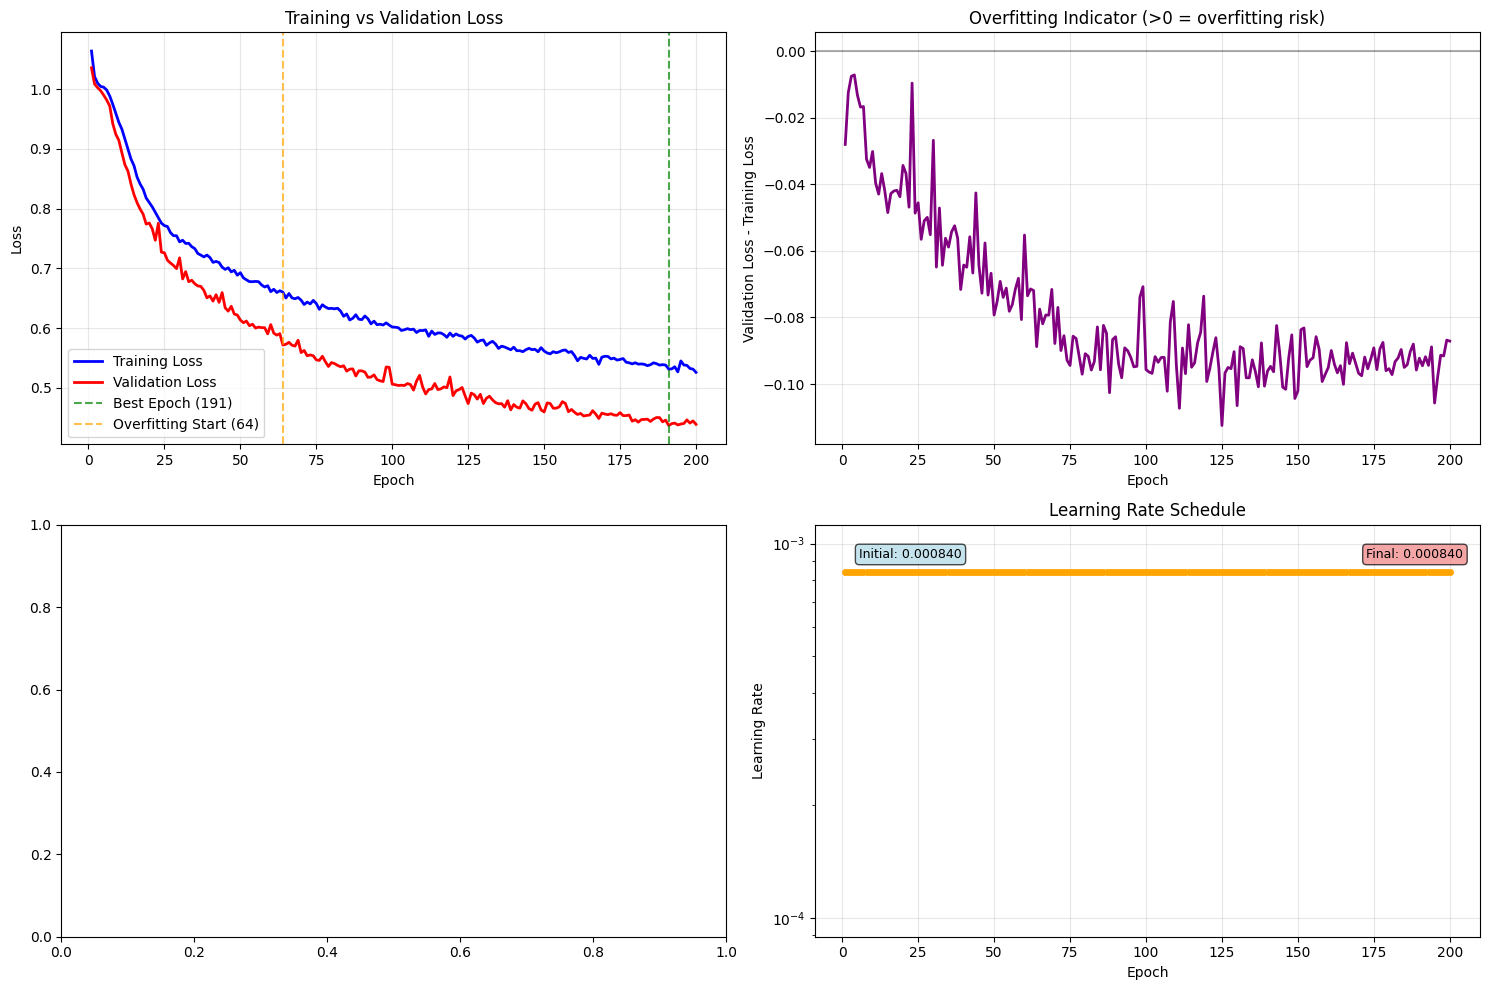


💡 RACCOMANDAZIONI:
🎯 RACCOMANDAZIONE: Ferma il training all'epoch 64
   Risparmio: 136 epoch inutili
➡️  Validation loss stabile: punto di convergenza raggiunto
➡️  Learning rate stabile: potresti aver bisogno di più epoch


In [17]:
X_example = combined_epochs.get_data()  
y_example = np.array([label_mapping[label] for label in patient_labels])  


net_result, monitor_result, history_result = run_extended_training_experiment(
    X_example, y_example, EXPERIMENT_CONFIG, "EEG_Neurodegenerative_Extended"
)

## ESPERIMENTO 2: Confronto con diversi numeri di epoch fissi

ESPERIMENTO 2: CONFRONTO EPOCH FISSI

🔄 Test con 20 epoch...

🚀 Avvio esperimento: Fixed_20_Epochs
📊 Dati: 35340 campioni, 19 canali, 1000 time points
🎯 Classi: 3 ([0 1 2])
⏱️  Training fino a 20 epoch (con early stopping)

📈 Inizio training...


  epoch    train_loss    valid_acc    valid_loss      lr       dur
-------  ------------  -----------  ------------  ------  --------
      1        1.0563       0.5052        1.0307  0.0050  241.3229
  epoch    train_loss    valid_acc    valid_loss      lr       dur
-------  ------------  -----------  ------------  ------  --------
      1        1.0563       0.5052        1.0307  0.0050  241.3229
      2        1.0188       0.5216        0.9956  0.0050  230.6656
      2        1.0188       0.5216        0.9956  0.0050  230.6656
      3        1.0067       0.5299        0.9868  0.0050  230.4673
      3        1.0067       0.5299        0.9868  0.0050  230.4673
      4        0.9990       0.5369        0.9749  0.0050  232.7405
      4        0.9990       0.5369        0.9749  0.0050  232.7405
      5        0.9917       0.5467        0.9678  0.0050  230.4540
      5        0.9917       0.5467        0.9678  0.0050  230.4540
      6        0.9845       0.5553        0.9516  0.0050  227.

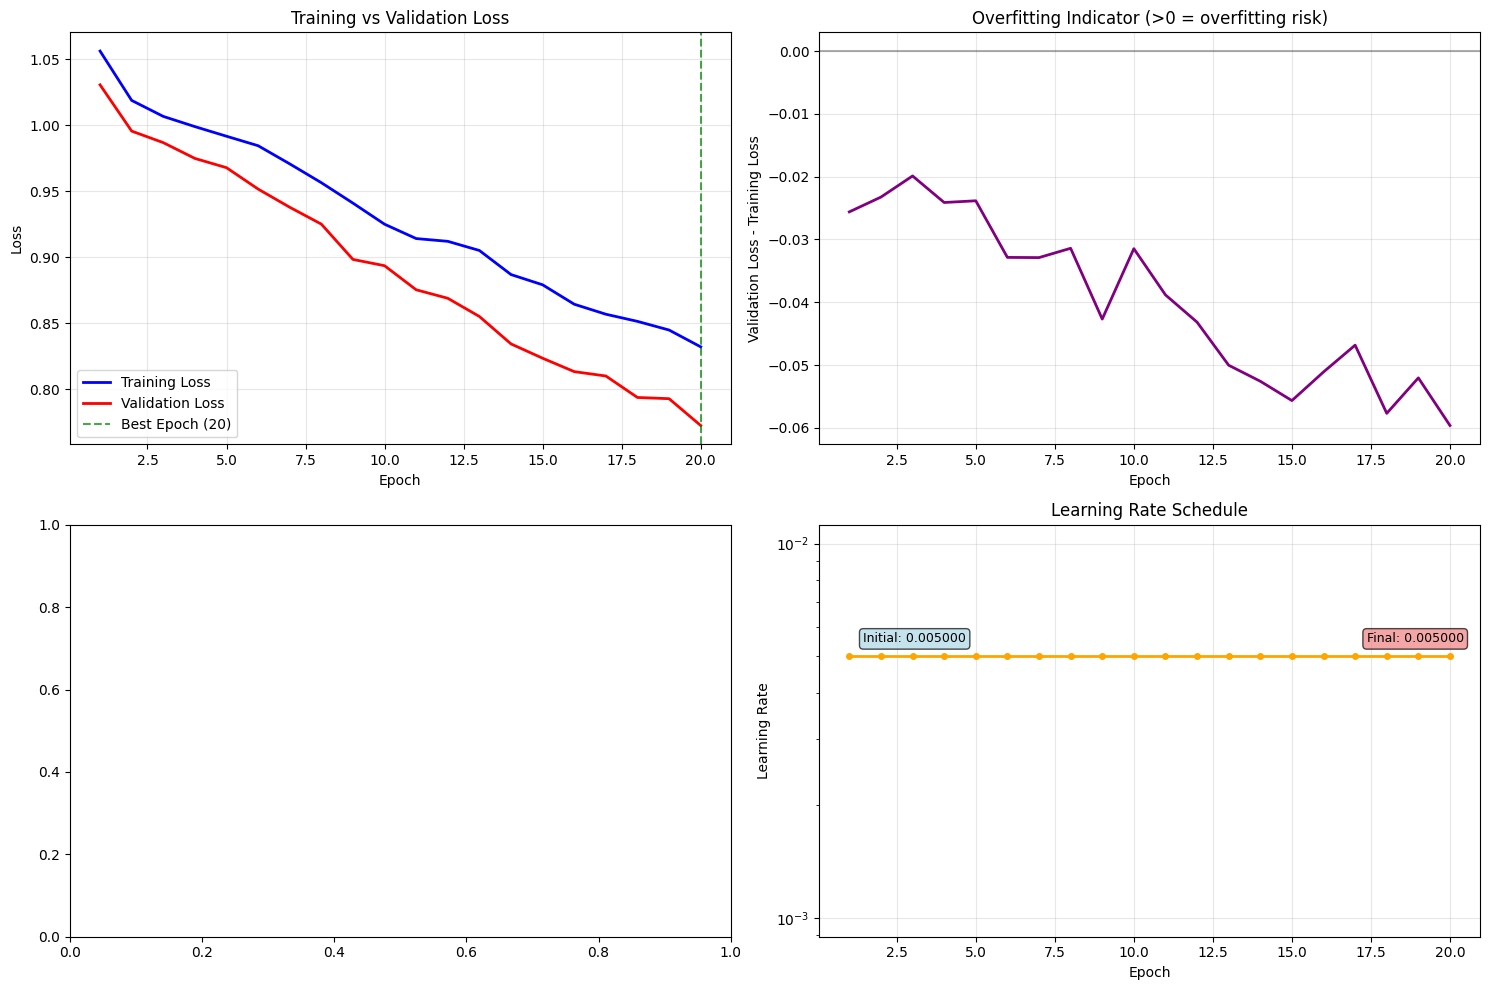


💡 RACCOMANDAZIONI:
📉 Validation loss ancora in discesa: potresti continuare
➡️  Learning rate stabile: potresti aver bisogno di più epoch

🔄 Test con 50 epoch...

🚀 Avvio esperimento: Fixed_50_Epochs
📊 Dati: 35340 campioni, 19 canali, 1000 time points
🎯 Classi: 3 ([0 1 2])
⏱️  Training fino a 50 epoch (con early stopping)

📈 Inizio training...
  epoch    train_loss    valid_acc    valid_loss      lr       dur
-------  ------------  -----------  ------------  ------  --------
      1        1.0676       0.4748        1.0488  0.0050  231.0805
  epoch    train_loss    valid_acc    valid_loss      lr       dur
-------  ------------  -----------  ------------  ------  --------
      1        1.0676       0.4748        1.0488  0.0050  231.0805
      2        1.0200       0.4880        1.0081  0.0050  231.9076
      2        1.0200       0.4880        1.0081  0.0050  231.9076
      3        1.0056       0.5132        1.0011  0.0050  234.5401
      3        1.0056       0.5132        1.0011  

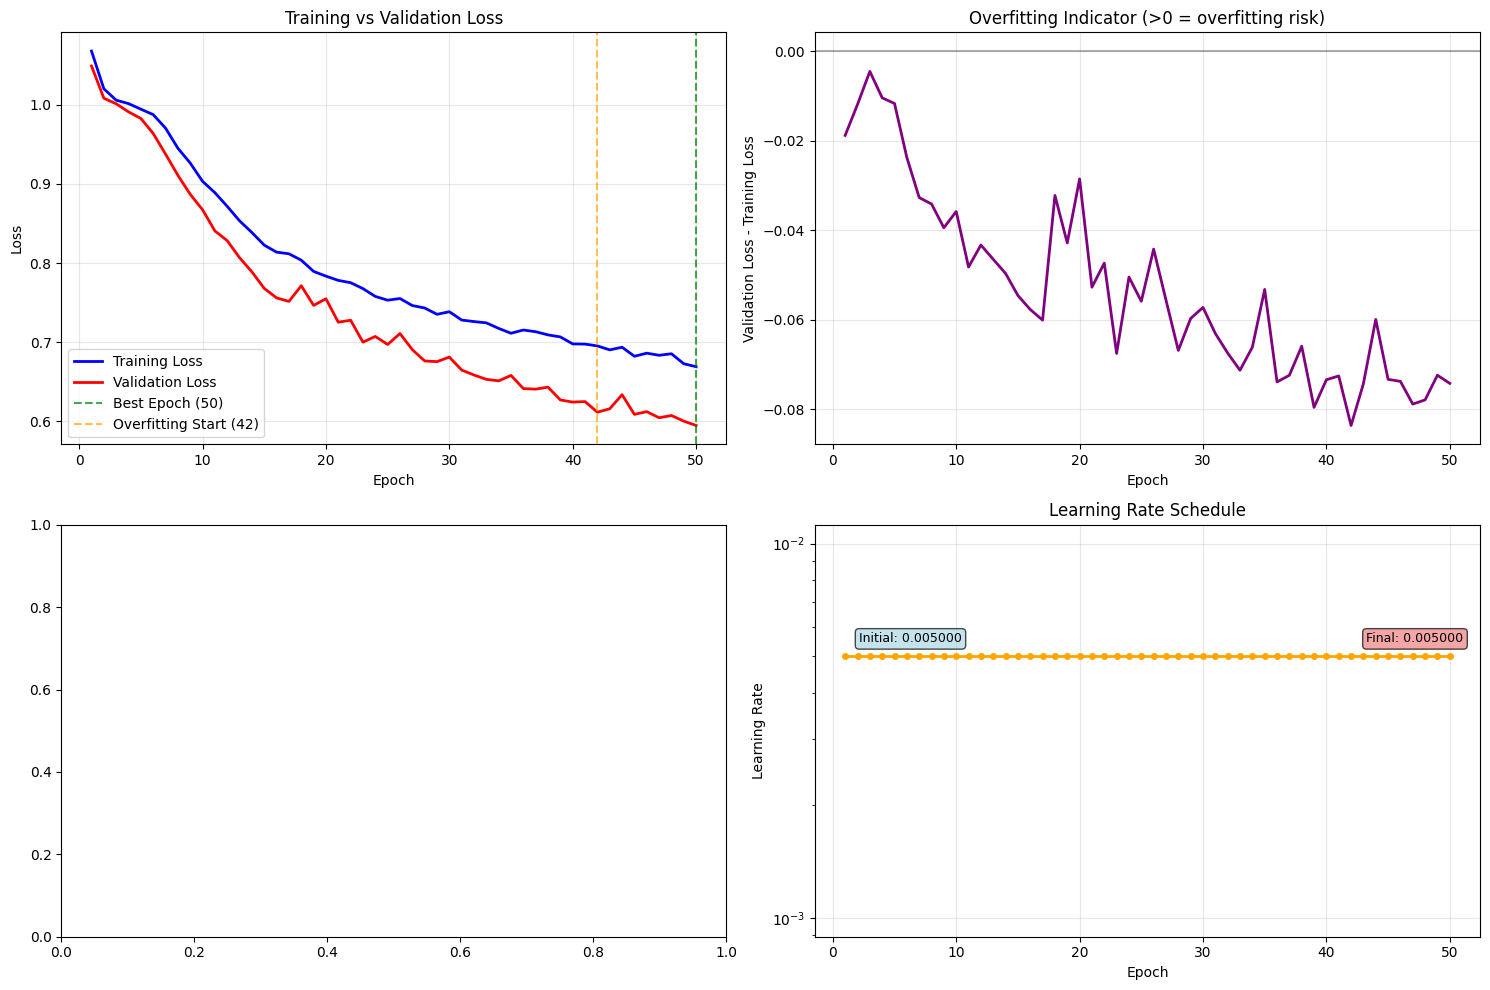


💡 RACCOMANDAZIONI:
🎯 RACCOMANDAZIONE: Ferma il training all'epoch 42
   Risparmio: 8 epoch inutili
📉 Validation loss ancora in discesa: potresti continuare
➡️  Learning rate stabile: potresti aver bisogno di più epoch

🔄 Test con 80 epoch...

🚀 Avvio esperimento: Fixed_80_Epochs
📊 Dati: 35340 campioni, 19 canali, 1000 time points
🎯 Classi: 3 ([0 1 2])
⏱️  Training fino a 80 epoch (con early stopping)

📈 Inizio training...
  epoch    train_loss    valid_acc    valid_loss      lr       dur
-------  ------------  -----------  ------------  ------  --------
      1        1.0647       0.4623        1.0351  0.0050  239.4085
  epoch    train_loss    valid_acc    valid_loss      lr       dur
-------  ------------  -----------  ------------  ------  --------
      1        1.0647       0.4623        1.0351  0.0050  239.4085
      2        1.0180       0.5235        0.9964  0.0050  236.3376
      2        1.0180       0.5235        0.9964  0.0050  236.3376
      3        1.0074       0.5168   

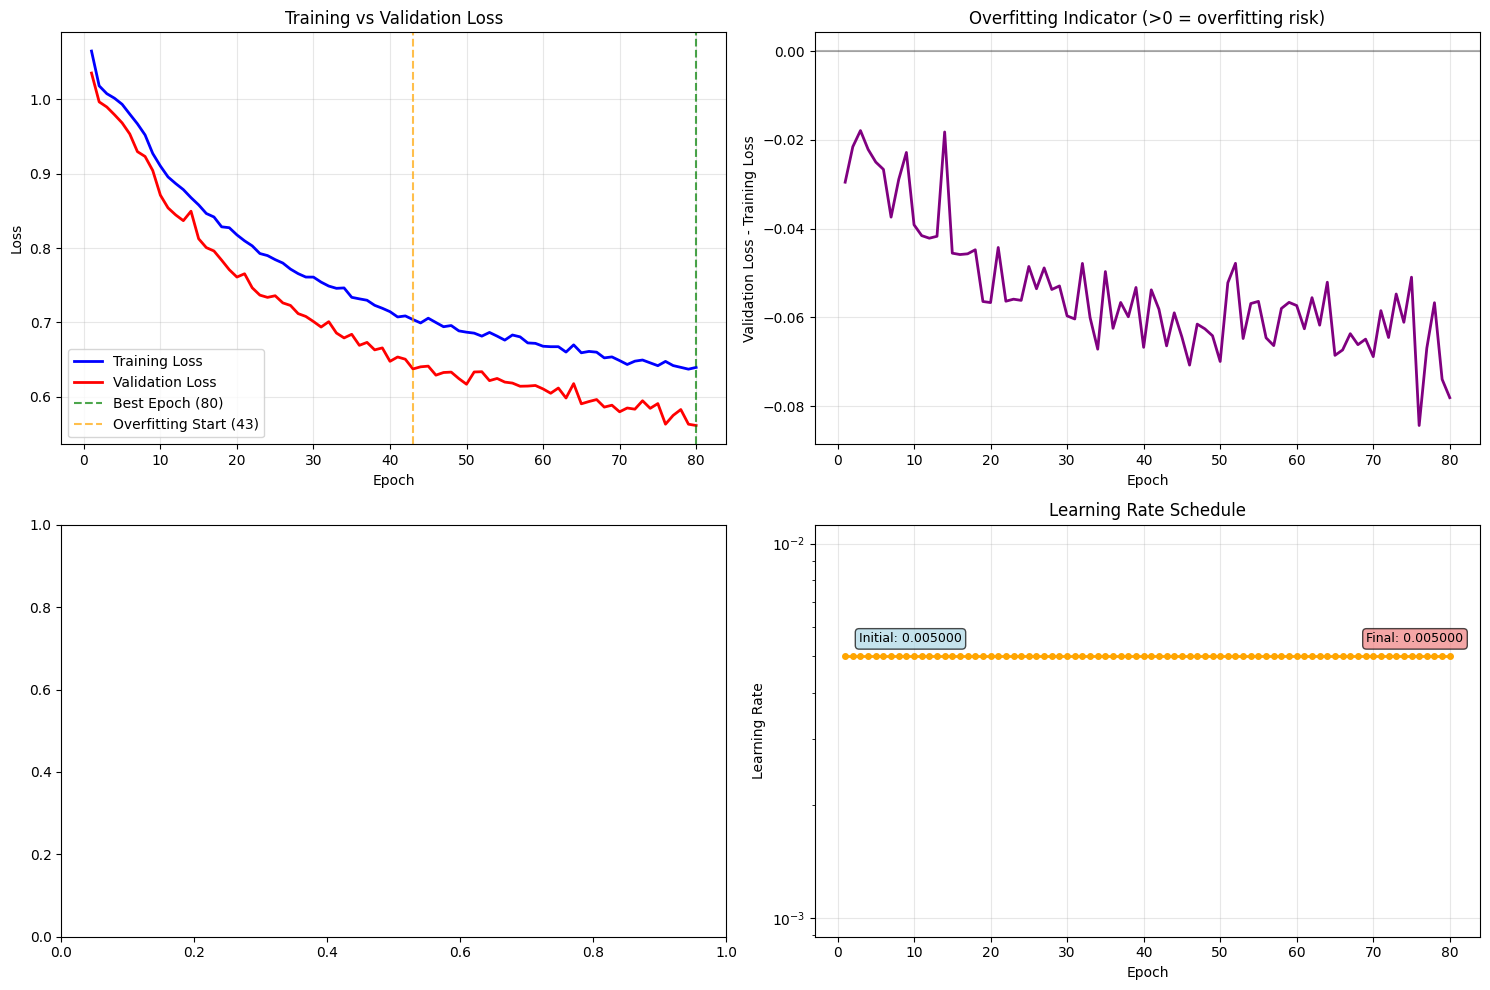


💡 RACCOMANDAZIONI:
🎯 RACCOMANDAZIONE: Ferma il training all'epoch 43
   Risparmio: 37 epoch inutili
📉 Validation loss ancora in discesa: potresti continuare
➡️  Learning rate stabile: potresti aver bisogno di più epoch

🔄 Test con 120 epoch...

🚀 Avvio esperimento: Fixed_120_Epochs
📊 Dati: 35340 campioni, 19 canali, 1000 time points
🎯 Classi: 3 ([0 1 2])
⏱️  Training fino a 120 epoch (con early stopping)

📈 Inizio training...
  epoch    train_loss    valid_acc    valid_loss      lr       dur
-------  ------------  -----------  ------------  ------  --------
      1        1.0576       0.4966        1.0252  0.0050  222.8674
  epoch    train_loss    valid_acc    valid_loss      lr       dur
-------  ------------  -----------  ------------  ------  --------
      1        1.0576       0.4966        1.0252  0.0050  222.8674
      2        1.0154       0.5240        0.9939  0.0050  228.9070
      2        1.0154       0.5240        0.9939  0.0050  228.9070
      3        1.0076       0.516

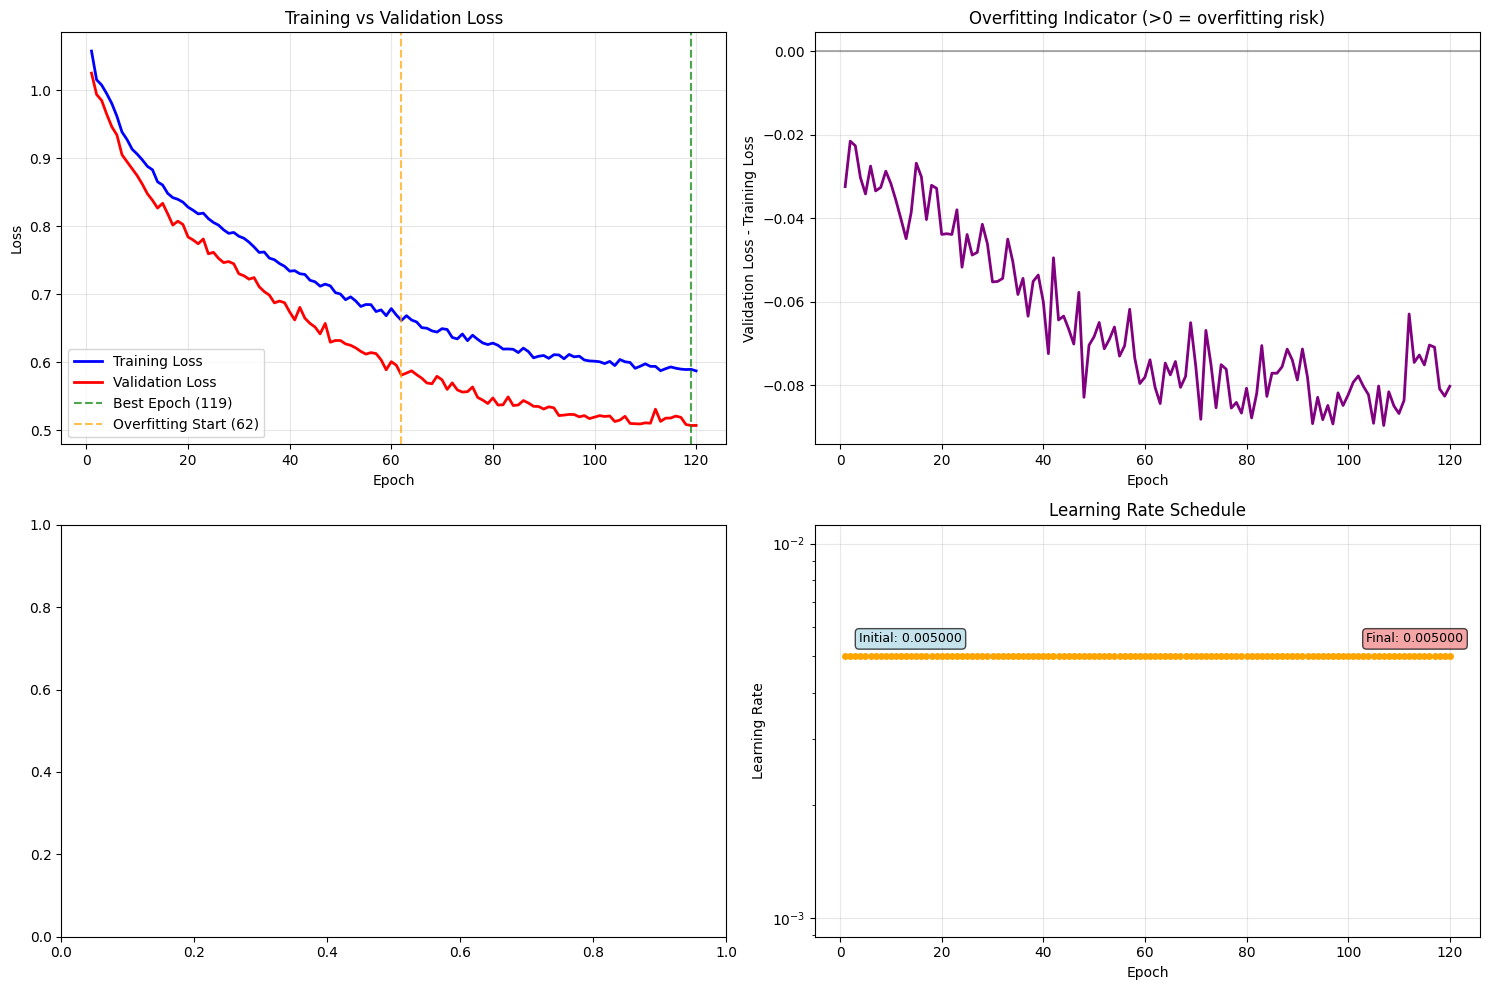


💡 RACCOMANDAZIONI:
🎯 RACCOMANDAZIONE: Ferma il training all'epoch 62
   Risparmio: 58 epoch inutili
📉 Validation loss ancora in discesa: potresti continuare
➡️  Learning rate stabile: potresti aver bisogno di più epoch

🔄 Test con 150 epoch...

🚀 Avvio esperimento: Fixed_150_Epochs
📊 Dati: 35340 campioni, 19 canali, 1000 time points
🎯 Classi: 3 ([0 1 2])
⏱️  Training fino a 150 epoch (con early stopping)

📈 Inizio training...
  epoch    train_loss    valid_acc    valid_loss      lr       dur
-------  ------------  -----------  ------------  ------  --------
      1        1.0408       0.5015        1.0142  0.0050  228.8408
  epoch    train_loss    valid_acc    valid_loss      lr       dur
-------  ------------  -----------  ------------  ------  --------
      1        1.0408       0.5015        1.0142  0.0050  228.8408
      2        1.0088       0.5051        1.0086  0.0050  230.8502
      2        1.0088       0.5051        1.0086  0.0050  230.8502
      3        0.9980       0.527

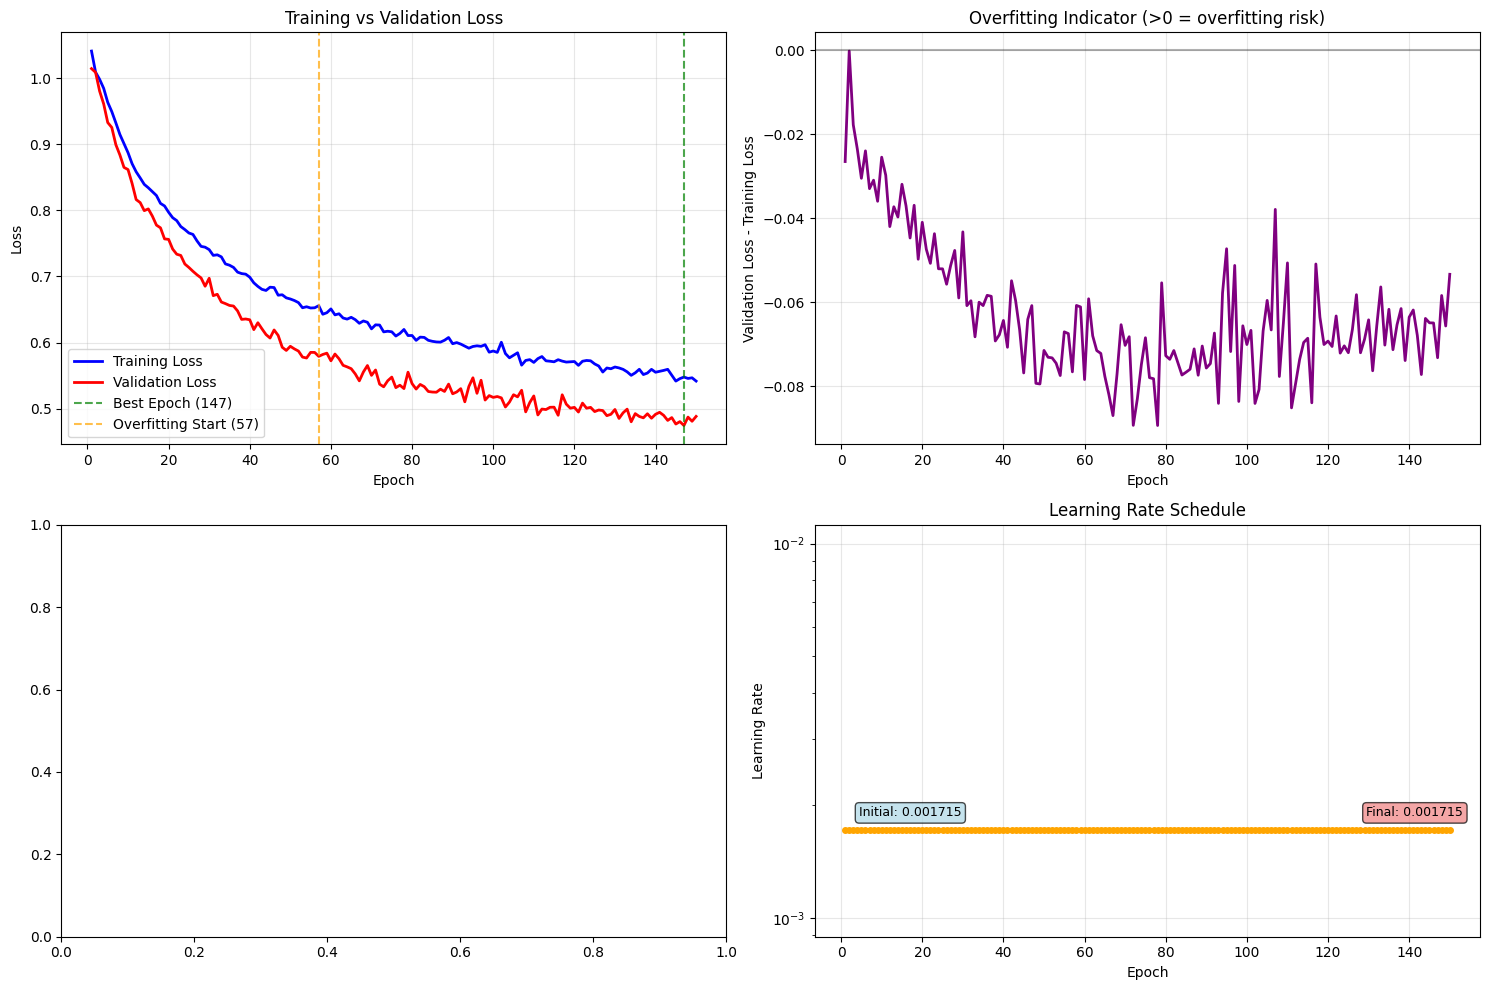


💡 RACCOMANDAZIONI:
🎯 RACCOMANDAZIONE: Ferma il training all'epoch 57
   Risparmio: 93 epoch inutili
➡️  Validation loss stabile: punto di convergenza raggiunto
➡️  Learning rate stabile: potresti aver bisogno di più epoch


In [ ]:

epoch_tests = [20, 50, 80, 120, 150]
results_comparison = {}


print("ESPERIMENTO 2: CONFRONTO EPOCH FISSI")


for n_epochs in epoch_tests:
    print(f"\n🔄 Test con {n_epochs} epoch...")
    
    # Crea configurazione temporanea
    temp_config = EXPERIMENT_CONFIG.copy()
    temp_config['max_epochs_exploration'] = n_epochs
    temp_config['patience_early_stopping'] = n_epochs + 10  # Disabilitare l'early stopping
    
    # Sostituisci con i tuoi dati:
    net_temp, monitor_temp, _ = run_extended_training_experiment(
        X, y, temp_config, f"Fixed_{n_epochs}_Epochs"
     )
    
    # Salvo
    results_comparison[n_epochs] = {
         'final_train_loss': monitor_temp.train_losses[-1],
         'final_valid_loss': monitor_temp.valid_losses[-1],
         'best_valid_loss': monitor_temp.best_valid_loss,
         'best_epoch': monitor_temp.best_epoch
     }

df = pd.DataFrame.from_dict(results_comparison, orient='index')
df.index.name = 'n_epochs'  # Diamo un nome all'indice


# Salva in un file CSV
df.to_csv('results_comparison.csv')

# Secondo modello

In [6]:
from skorch.dataset import ValidSplit
from braindecode import EEGClassifier
from torch.nn import CrossEntropyLoss
from skorch.callbacks import EarlyStopping

# La configurazione della rete
net = EEGClassifier(
    'Deep4Net',
    callbacks=[
        EarlyStopping(patience=10, threshold=0.001, monitor='valid_loss')
    ],
    module__final_conv_length='auto',
    train_split = ValidSplit(0.3),
    batch_size = 32,
    lr = 0.005,
    max_epochs = 50,
    criterion = CrossEntropyLoss(),
)

In [7]:
print(net)

<class 'braindecode.classifier.EEGClassifier'>[uninitialized](
  module=Deep4Net,
  module__final_conv_length=auto,
)


In [8]:
#Addestramento della rete con tutti i soggetti 

# Definisci un mapping da stringa a intero
label_mapping = {'A': 0, 'C': 1, 'F': 2}

# Ottieni i dati delle epoche
X = combined_epochs.get_data()  # Forma risultante: (n_epochs, n_channels, n_times)

# Assicurati che le etichette siano un array numpy 1D di interi
y = np.array([label_mapping[label] for label in patient_labels])

# Ora puoi adattare il modello
net.fit(X, y)

/Users/bobo/Library/Python/3.9/lib/python/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_loss    valid_acc    valid_loss       dur
-------  ------------  -----------  ------------  --------
      1        1.1878       0.5246        1.0014  140.1141
      2        1.0616       0.4565        1.0372  174.7203
      3        1.0062       0.5147        0.9932  178.5221
      4        0.9650       0.5584        0.9340  180.6259
      5        0.9161       0.5186        0.9727  185.0436
      6        0.8850       0.4814        1.0588  189.1689
      7        0.8519       0.5158        0.9926  190.6356
      8        0.8211       0.5507        0.9750  180.6398
      9        0.7935       0.6155        0.8601  185.9571
     10        0.7664       0.6076        0.8897  178.8688
     11        0.7458       0.6497        0.8443  193.9173
     12        0.7217       0.5930        0.9119  192.6085
     13        0.6975       0.6121        0.8768  190.2632
     14        0.6804       0.5821        0.9650  188.7533
     15        0.6679       0.6473        0.8361  178.35

<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=============================================================================================================================================
  Layer (type (var_name):depth-idx)        Input Shape               Output Shape              Param #                   Kernel Shape
  ============================================================================================================================================
  Deep4Net (Deep4Net)                      [1, 19, 1000]             [1, 3]                    --                        --
  ├─Ensure4d (ensuredims): 1-1             [1, 19, 1000]             [1, 19, 1000, 1]          --                        --
  ├─Rearrange (dimshuffle): 1-2            [1, 19, 1000, 1]          [1, 1, 1000, 19]          --                        --
  ├─CombinedConv (conv_time_spat): 1-3     [1, 1, 1000, 19]          [1, 25, 991, 1]           12,150                    --
  ├─BatchNorm2d (bnorm): 1-4               [1, 25, 991, 1]           [1, 25, 991, 1]           50                        --
  ├─Expression (conv_nonlin): 1-5          [1, 25, 991, 1]           [1, 25, 991, 1]           --                        --
  ├─MaxPool2d (pool): 1-6                  [1, 25, 991, 1]           [1, 25, 330, 1]           --                        [3, 1]
  ├─Expression (pool_nonlin): 1-7          [1, 25, 330, 1]           [1, 25, 330, 1]           --                        --
  ├─Dropout (drop_2): 1-8                  [1, 25, 330, 1]           [1, 25, 330, 1]           --                        --
  ├─Conv2d (conv_2): 1-9                   [1, 25, 330, 1]           [1, 50, 321, 1]           12,500                    [10, 1]
  ├─BatchNorm2d (bnorm_2): 1-10            [1, 50, 321, 1]           [1, 50, 321, 1]           100                       --
  ├─Expression (nonlin_2): 1-11            [1, 50, 321, 1]           [1, 50, 321, 1]           --                        --
  ├─MaxPool2d (pool_2): 1-12               [1, 50, 321, 1]           [1, 50, 107, 1]           --                        [3, 1]
  ├─Expression (pool_nonlin_2): 1-13       [1, 50, 107, 1]           [1, 50, 107, 1]           --                        --
  ├─Dropout (drop_3): 1-14                 [1, 50, 107, 1]           [1, 50, 107, 1]           --                        --
  ├─Conv2d (conv_3): 1-15                  [1, 50, 107, 1]           [1, 100, 98, 1]           50,000                    [10, 1]
  ├─BatchNorm2d (bnorm_3): 1-16            [1, 100, 98, 1]           [1, 100, 98, 1]           200                       --
  ├─Expression (nonlin_3): 1-17            [1, 100, 98, 1]           [1, 100, 98, 1]           --                        --
  ├─MaxPool2d (pool_3): 1-18               [1, 100, 98, 1]           [1, 100, 32, 1]           --                        [3, 1]
  ├─Expression (pool_nonlin_3): 1-19       [1, 100, 32, 1]           [1, 100, 32, 1]           --                        --
  ├─Dropout (drop_4): 1-20                 [1, 100, 32, 1]           [1, 100, 32, 1]           --                        --
  ├─Conv2d (conv_4): 1-21                  [1, 100, 32, 1]           [1, 200, 23, 1]           200,000                   [10, 1]
  ├─BatchNorm2d (bnorm_4): 1-22            [1, 200, 23, 1]           [1, 200, 23, 1]           400                       --
  ├─Expression (nonlin_4): 1-23            [1, 200, 23, 1]           [1, 200, 23, 1]           --                        --
  ├─MaxPool2d (pool_4): 1-24               [1, 200, 23, 1]           [1, 200, 7, 1]            --                        [3, 1]
  ├─Expression (pool_nonlin_4): 1-25       [1, 200, 7, 1]            [1, 200, 7, 1]            --                        --
  ├─Sequential (final_layer): 1-26         [1, 200, 7, 1]            [1, 3]                    --                        --
  │    └─Conv2d (conv_classifier): 2-1     [1, 200, 7, 1]            [1, 3, 1, 1]              4,203                     [7, 1]
  │ 


🚀 Avvio esperimento: EEG_Neurodegenerative_Extended_Deep
📊 Dati: 35340 campioni, 19 canali, 1000 time points
🎯 Classi: 3 ([0 1 2])
⏱️  Training fino a 200 epoch (con early stopping)

📈 Inizio training...
Re-initializing module because the following parameters were re-set: final_conv_length, n_chans, n_outputs, n_times.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss       dur
-------  ------------  -----------  ------------  --------
      1        1.1755       0.4473        1.0482  181.9262
      2        1.0586       0.4448        1.0742  183.0960
      3        1.0038       0.4766        1.0203  195.0478
      4        0.9633       0.5402        0.9525  196.5333
      5        0.9288       0.5687        0.9299  194.2741
      6        0.8934       0.5155        0.9876  196.8131
      7        0.8611       0.5753        0.9058  197.1314
      8        0.8266       0.5735        0.8664  198.4509
      9        0.7991       0.5845

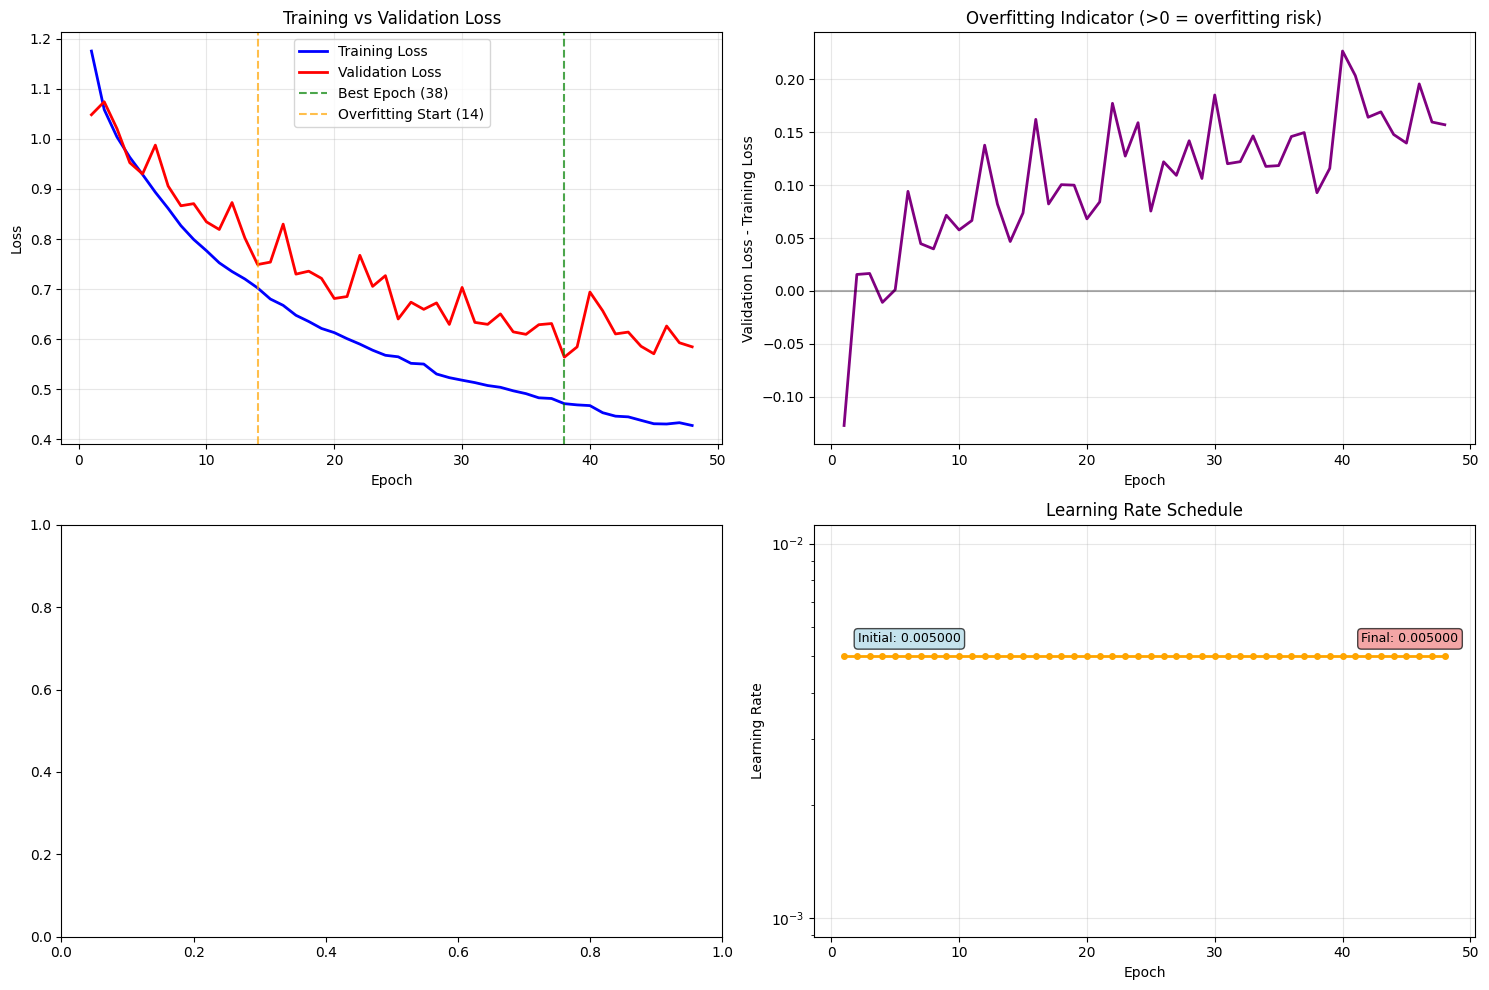


💡 RACCOMANDAZIONI:
🎯 RACCOMANDAZIONE: Ferma il training all'epoch 14
   Risparmio: 34 epoch inutili
✅ Il miglior modello è all'epoch 38
   Il training potrebbe essere accorciato
📉 Validation loss ancora in discesa: potresti continuare
➡️  Learning rate stabile: potresti aver bisogno di più epoch


In [12]:
# Esp1
X_example = combined_epochs.get_data()  
y_example = np.array([label_mapping[label] for label in patient_labels])  


net_result, monitor_result, history_result = run_extended_training_experiment(
    X_example, y_example, EXPERIMENT_CONFIG, "EEG_Neurodegenerative_Extended_Deep", net
)

ESPERIMENTO 2: CONFRONTO EPOCH FISSI

🔄 Test con 20 epoch...

🚀 Avvio esperimento: Fixed_20_Epochs_Deep
📊 Dati: 35340 campioni, 19 canali, 1000 time points
🎯 Classi: 3 ([0 1 2])
⏱️  Training fino a 20 epoch (con early stopping)

📈 Inizio training...
Re-initializing module because the following parameters were re-set: final_conv_length, n_chans, n_outputs, n_times.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss       dur
-------  ------------  -----------  ------------  --------
      1        1.1904       0.3154        1.1514  143.0614
      2        1.0442       0.5098        0.9900  159.8595
      3        0.9998       0.4927        1.0162  165.2244
      4        0.9588       0.5327        0.9740  168.8973
      5        0.9191       0.5611        0.9328  179.5850
      6        0.8821       0.5215        1.0022  184.1993
      7        0.8499       0.5936        0.8980  189.4408
      8        0.8160       0.5831        0.9217

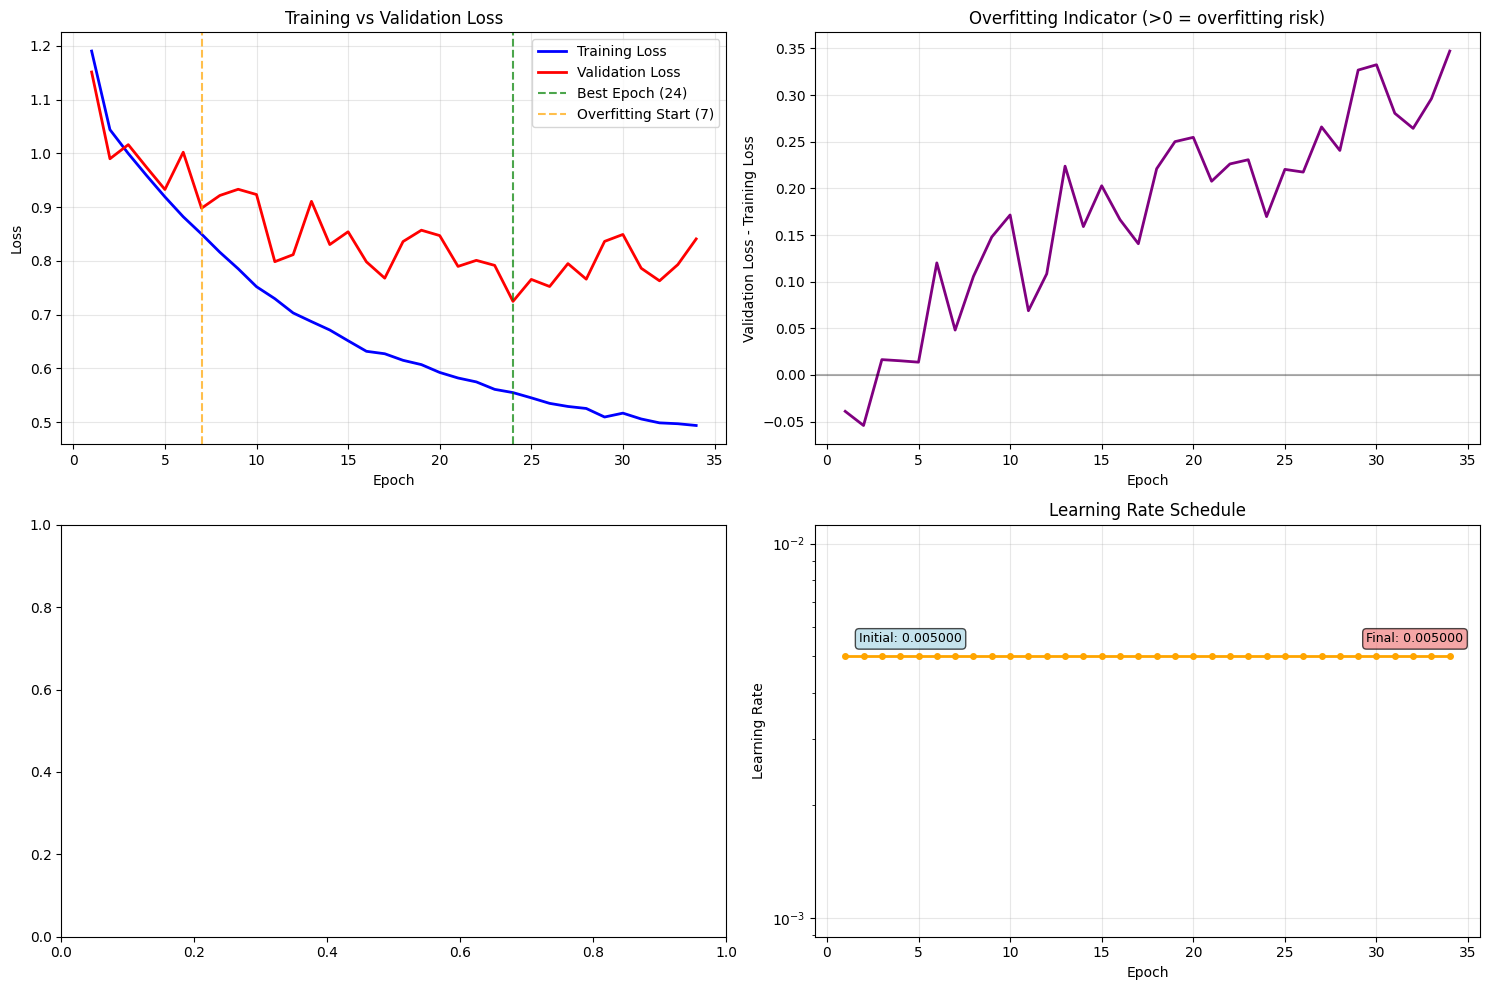


💡 RACCOMANDAZIONI:
🎯 RACCOMANDAZIONE: Ferma il training all'epoch 7
   Risparmio: 27 epoch inutili
✅ Il miglior modello è all'epoch 24
   Il training potrebbe essere accorciato
📈 Validation loss in crescita: possibile overfitting
➡️  Learning rate stabile: potresti aver bisogno di più epoch

🔄 Test con 50 epoch...

🚀 Avvio esperimento: Fixed_50_Epochs_Deep
📊 Dati: 35340 campioni, 19 canali, 1000 time points
🎯 Classi: 3 ([0 1 2])
⏱️  Training fino a 50 epoch (con early stopping)

📈 Inizio training...
Re-initializing module because the following parameters were re-set: final_conv_length, n_chans, n_outputs, n_times.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss       dur
-------  ------------  -----------  ------------  --------
      1        1.1884       0.5187        1.0065  182.0685
      2        1.0501       0.4516        1.1006  192.3893
      3        0.9968       0.5265        0.9673  181.9722
      4        0.9568       

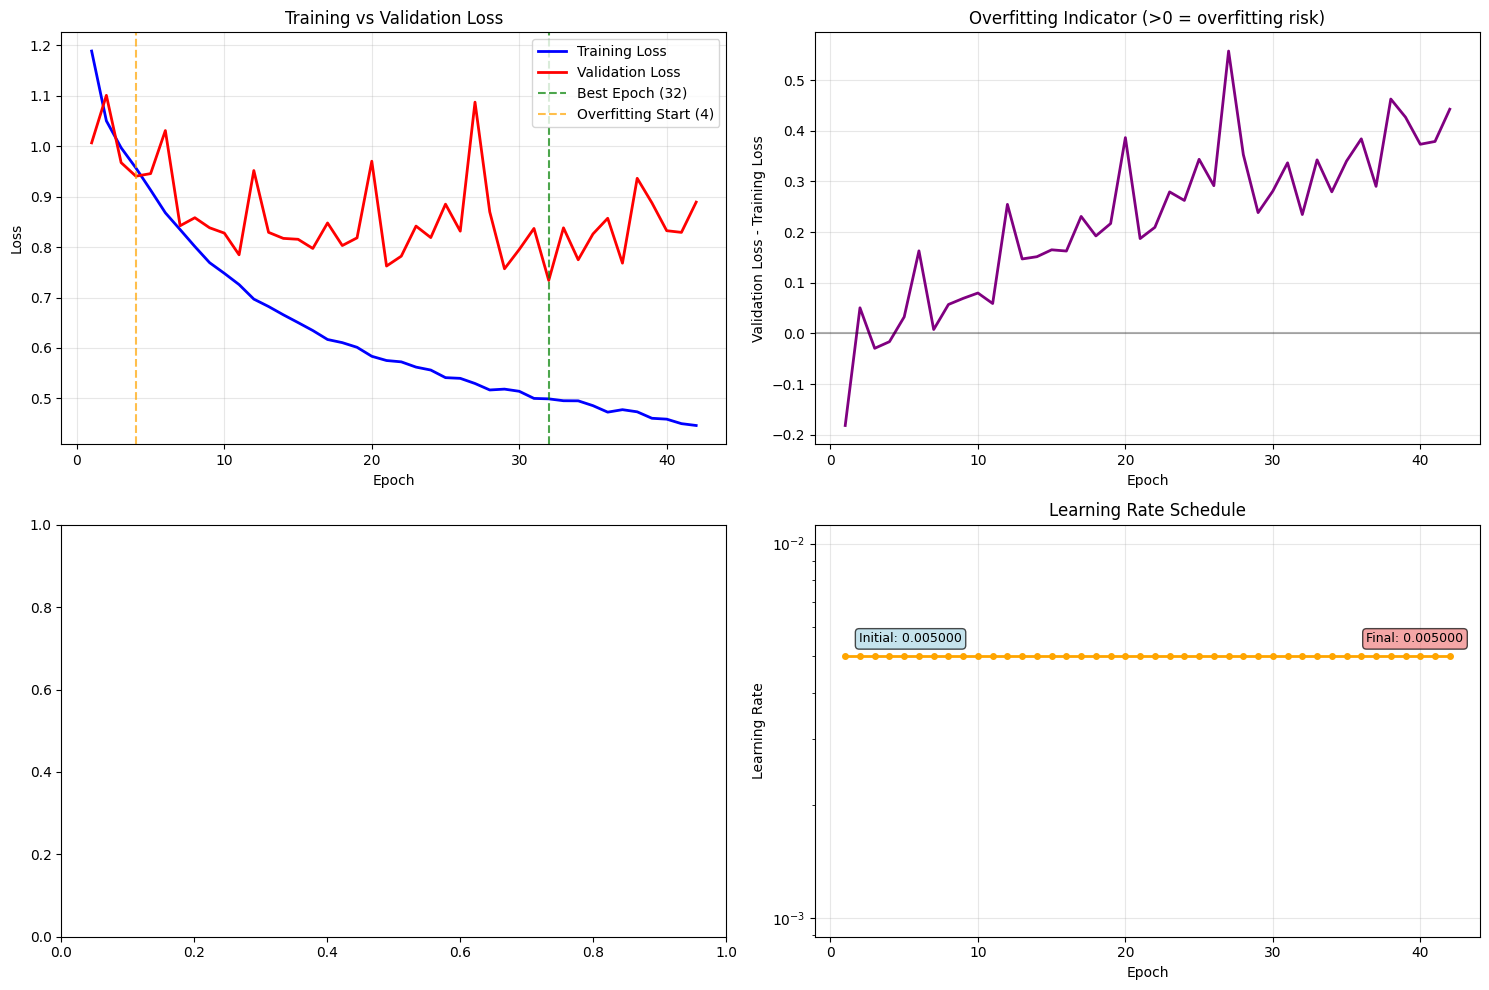


💡 RACCOMANDAZIONI:
🎯 RACCOMANDAZIONE: Ferma il training all'epoch 4
   Risparmio: 38 epoch inutili
✅ Il miglior modello è all'epoch 32
   Il training potrebbe essere accorciato
📈 Validation loss in crescita: possibile overfitting
➡️  Learning rate stabile: potresti aver bisogno di più epoch

🔄 Test con 80 epoch...

🚀 Avvio esperimento: Fixed_80_Epochs_Deep
📊 Dati: 35340 campioni, 19 canali, 1000 time points
🎯 Classi: 3 ([0 1 2])
⏱️  Training fino a 80 epoch (con early stopping)

📈 Inizio training...
Re-initializing module because the following parameters were re-set: final_conv_length, n_chans, n_outputs, n_times.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss       dur
-------  ------------  -----------  ------------  --------
      1        1.1932       0.5015        1.0029  188.3948
      2        1.0639       0.4847        0.9950  185.8939
      3        1.0091       0.4879        1.0085  189.5302
      4        0.9583       

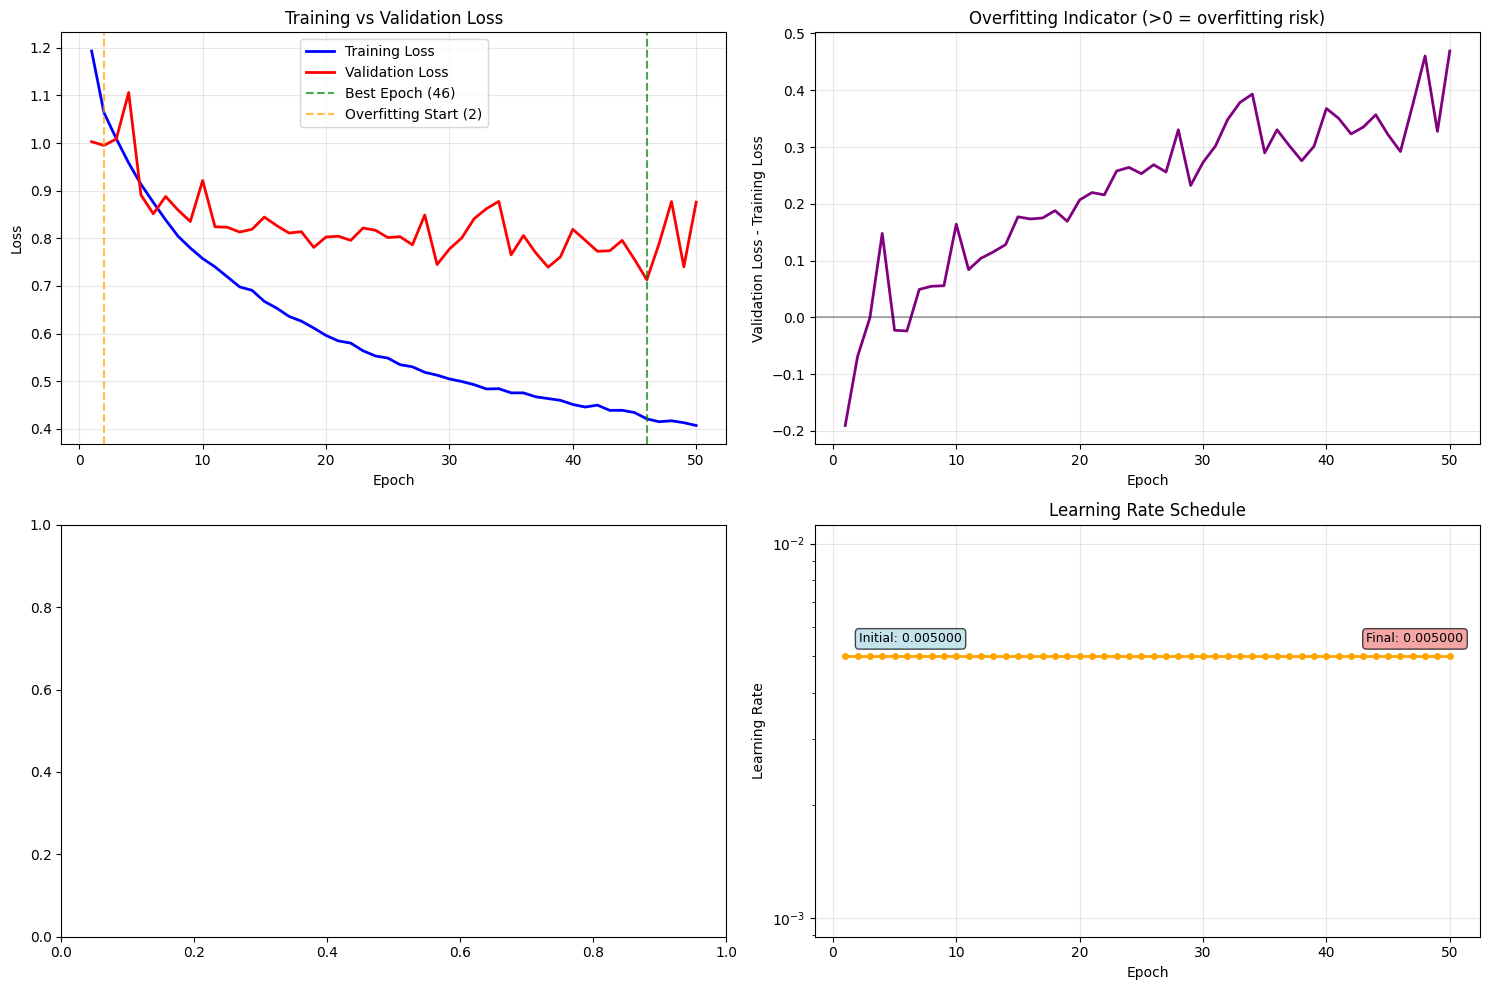


💡 RACCOMANDAZIONI:
🎯 RACCOMANDAZIONE: Ferma il training all'epoch 2
   Risparmio: 48 epoch inutili
📈 Validation loss in crescita: possibile overfitting
➡️  Learning rate stabile: potresti aver bisogno di più epoch

🔄 Test con 120 epoch...

🚀 Avvio esperimento: Fixed_120_Epochs_Deep
📊 Dati: 35340 campioni, 19 canali, 1000 time points
🎯 Classi: 3 ([0 1 2])
⏱️  Training fino a 120 epoch (con early stopping)

📈 Inizio training...
Re-initializing module because the following parameters were re-set: final_conv_length, n_chans, n_outputs, n_times.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss       dur
-------  ------------  -----------  ------------  --------
      1        1.1818       0.4605        1.1004  181.0941
      2        1.0547       0.4648        1.0763  184.9355
      3        1.0029       0.4925        1.0162  182.8205
      4        0.9591       0.5126        0.9925  181.0226
      5        0.9132       0.4957        1.

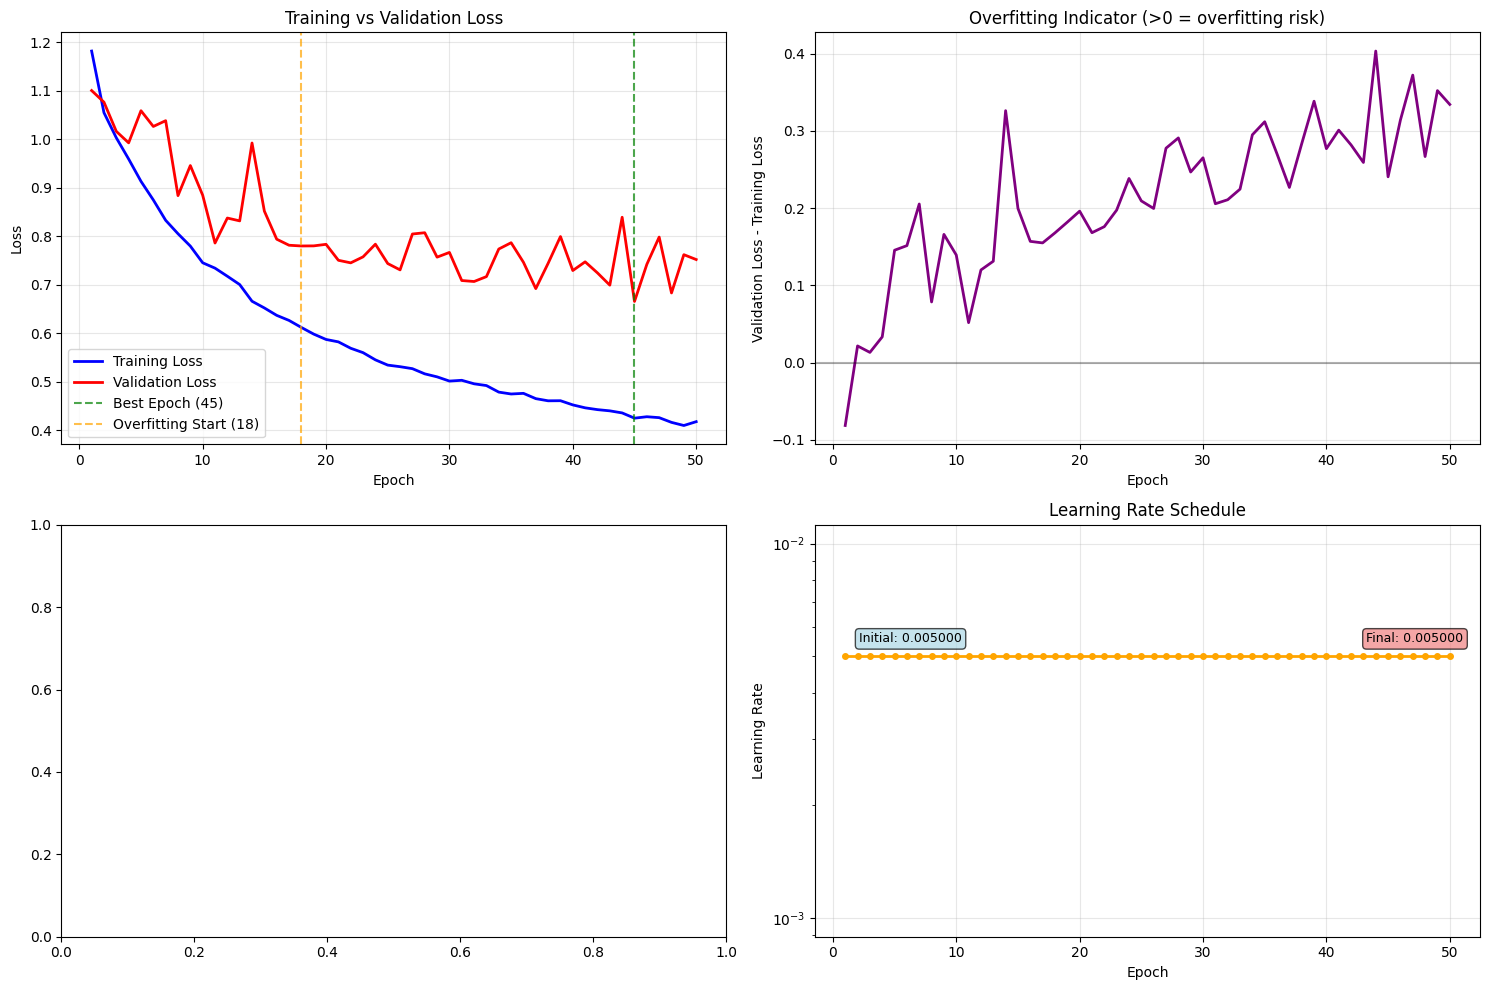


💡 RACCOMANDAZIONI:
🎯 RACCOMANDAZIONE: Ferma il training all'epoch 18
   Risparmio: 32 epoch inutili
📈 Validation loss in crescita: possibile overfitting
➡️  Learning rate stabile: potresti aver bisogno di più epoch

🔄 Test con 150 epoch...

🚀 Avvio esperimento: Fixed_150_Epochs_Deep
📊 Dati: 35340 campioni, 19 canali, 1000 time points
🎯 Classi: 3 ([0 1 2])
⏱️  Training fino a 150 epoch (con early stopping)

📈 Inizio training...
Re-initializing module because the following parameters were re-set: final_conv_length, n_chans, n_outputs, n_times.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss       dur
-------  ------------  -----------  ------------  --------
      1        1.1976       0.5091        1.0031  181.5372
      2        1.0626       0.4566        1.0370  183.1312
      3        1.0142       0.5210        0.9935  184.2619
      4        0.9817       0.5457        0.9584  182.4664
      5        0.9428       0.5305        0

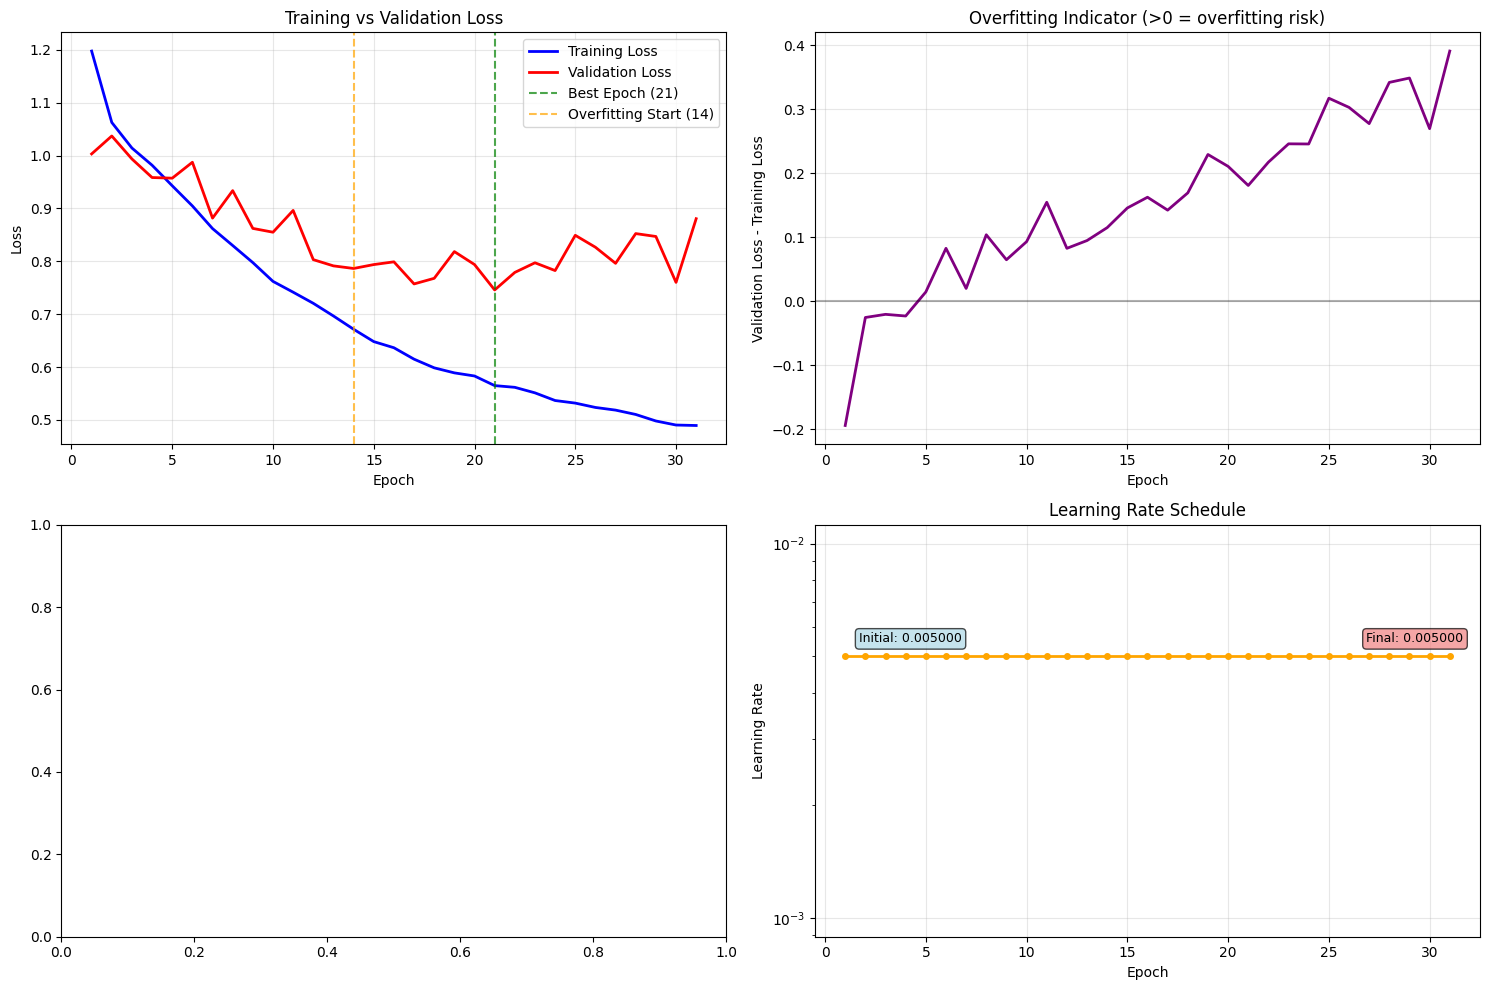


💡 RACCOMANDAZIONI:
🎯 RACCOMANDAZIONE: Ferma il training all'epoch 14
   Risparmio: 17 epoch inutili
✅ Il miglior modello è all'epoch 21
   Il training potrebbe essere accorciato
📈 Validation loss in crescita: possibile overfitting
➡️  Learning rate stabile: potresti aver bisogno di più epoch


In [13]:

epoch_tests = [20, 50, 80, 120, 150]
results_comparison = {}


print("ESPERIMENTO 2: CONFRONTO EPOCH FISSI")


for n_epochs in epoch_tests:
    print(f"\n🔄 Test con {n_epochs} epoch...")
    
    # Crea configurazione temporanea
    temp_config = EXPERIMENT_CONFIG.copy()
    temp_config['max_epochs_exploration'] = n_epochs
    temp_config['patience_early_stopping'] = n_epochs + 10  # Disabilitare l'early stopping
    
    # Sostituisci con i tuoi dati:
    net_temp, monitor_temp, _ = run_extended_training_experiment(
        X, y, temp_config, f"Fixed_{n_epochs}_Epochs_Deep",net
     )
    
    # Salvo
    results_comparison[n_epochs] = {
         'final_train_loss': monitor_temp.train_losses[-1],
         'final_valid_loss': monitor_temp.valid_losses[-1],
         'best_valid_loss': monitor_temp.best_valid_loss,
         'best_epoch': monitor_temp.best_epoch
     }

df = pd.DataFrame.from_dict(results_comparison, orient='index')
df.index.name = 'n_epochs'  # Diamo un nome all'indice

# Salva in un file CSV
df.to_csv('results_comparison.csv')

In [ ]:
#LOSO DEEP

import os 

# label_mapping= {'C': 0, 'A': 1},  # esempio
#Contro_vs_Alzheimer": {'C': 0, 'A': 1}
#Contro_vs_Frontotemporal": {'C': 0, 'F': 1}
#Frontotemporal_vs_Alzheimer": {'A': 0, 'F': 1}
#"Contro_vs_Patologici": {'C': 0, 'A': 1, 'F': 1}

experiment = [
    {
"name":  "Contro_vs_Alzheimer",
"labels" : {'C': 0, 'A': 1}
    },
    {
"name":  "Contro_vs_Frontotemporal",
"labels" : {'C': 0, 'F': 1}
    },
    {
"name":  "Frontotemporal_vs_Alzheimer",
"labels" : {'A': 0, 'F': 1}
    },
    {
"name":  "Contro_vs_Patologici",
"labels" : {'C': 0, 'A': 1, 'F': 1}
    }

]

def train_fn(X_train, y_train):
    net.fit(X_train, y_train)
    return net


memmap_dir = "experiment_loso/Deep4Net"
#os.makedirs(memmap_dir, exist_ok=True)


all_subjects = list(true_labels.keys())

for exp in experiment:
# Filtra solo i soggetti che appartengono alle classi desiderate (es. Contro vs Alzheimer)
    filtered_subjects = {s: l for s, l in true_labels.items() if l in list(exp['labels'].keys())}
    filtered_labels = {s: true_labels[s] for s in filtered_subjects}
    filtered_recordings = {s: subject_to_recordings[s] for s in filtered_subjects}

    print(f"Filtered subjects: {filtered_subjects.keys()}")
    print(f"number of subjects: {len(filtered_subjects)}")
    print(f"Filtered labels: { set(filtered_labels.values()) }")
    print(f"Filtered recordings: {filtered_recordings.keys()}")
    # Esegui l'esperimento

    run_loso_experiment(
        all_subjects=filtered_subjects,
        true_labels=filtered_labels,
        subject_to_recordings=filtered_recordings,
        label_mapping=exp['labels'],
        train_fn=train_fn,
        experiment_name= exp['name'],
        filename= memmap_dir
    )


Filtered subjects: dict_keys(['sub-001', 'sub-002', 'sub-003', 'sub-004', 'sub-005', 'sub-006', 'sub-007', 'sub-008', 'sub-009', 'sub-010', 'sub-011', 'sub-012', 'sub-013', 'sub-014', 'sub-015', 'sub-016', 'sub-017', 'sub-018', 'sub-019', 'sub-020', 'sub-021', 'sub-022', 'sub-023', 'sub-024', 'sub-025', 'sub-026', 'sub-027', 'sub-028', 'sub-029', 'sub-030', 'sub-031', 'sub-032', 'sub-033', 'sub-034', 'sub-035', 'sub-036', 'sub-037', 'sub-038', 'sub-039', 'sub-040', 'sub-041', 'sub-042', 'sub-043', 'sub-044', 'sub-045', 'sub-046', 'sub-047', 'sub-048', 'sub-049', 'sub-050', 'sub-051', 'sub-052', 'sub-053', 'sub-054', 'sub-055', 'sub-056', 'sub-057', 'sub-058', 'sub-059', 'sub-060', 'sub-061', 'sub-062', 'sub-063', 'sub-064', 'sub-065'])
number of subjects: 65
Filtered labels: {'C', 'A'}
Filtered recordings: dict_keys(['sub-001', 'sub-002', 'sub-003', 'sub-004', 'sub-005', 'sub-006', 'sub-007', 'sub-008', 'sub-009', 'sub-010', 'sub-011', 'sub-012', 'sub-013', 'sub-014', 'sub-015', 'sub-0

: 